In [1]:
import torch
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentinel = 1337

In [2]:
def search_alpha_parallel(sol, V_start, radius, t_eval, L):

    if sol.dim() > 1:
      sol = sol[:, 1:]
    else:
      sol = sol[1:]
    t_eval = t_eval[1:]
    ceiling = 1e5
    alpha_h = torch.tensor([1], device = device)*torch.ones_like(V_start)
    alpha_l = torch.tensor([-1], device = device)*torch.ones_like(V_start)
    mask = V_start - radius > 0
    if sol.dim() > 1:
      r = radius.unsqueeze(1).expand(sol.size())
    else:
      r = radius.unsqueeze(0).expand(sol.size())

    if True:
      condition_h = torch.min(sol*torch.exp(torch.outer(alpha_h,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_h,t_eval))), dim = 1).values > V_start - radius
      condition_l = torch.min(sol*torch.exp(torch.outer(alpha_l,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_l,t_eval))), dim = 1).values < V_start - radius


    while torch.any((~condition_h) & mask) or torch.any((~condition_l) & mask):
      alpha_h[~condition_h] = alpha_h[~condition_h]*2
      alpha_l[~condition_l] = alpha_l[~condition_l]*2
      if True:
        condition_h = torch.min(sol*torch.exp(torch.outer(alpha_h,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_h,t_eval))), dim = 1).values > V_start - radius
        condition_l = torch.min(sol*torch.exp(torch.outer(alpha_l,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_l,t_eval))), dim = 1).values < V_start - radius

    alpha_l[~mask] = alpha_h[~mask]
    alpha_mid = (alpha_h+alpha_l)/2
    while torch.max(torch.abs(alpha_h-alpha_l))>0.0001:
        if True:
          condition = torch.min(sol*torch.exp(torch.outer(alpha_mid,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_mid,t_eval))), dim = 1).values < V_start - radius

        alpha_l[condition] = alpha_mid[condition]
        alpha_h[~condition] = alpha_mid[~condition]
        alpha_mid = (alpha_h+alpha_l)/2

    alpha_mid[~mask] = -float('inf')
    indices = torch.argmin(sol*torch.exp(torch.outer(alpha_mid,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha_mid,t_eval))), dim = 1)
    return alpha_mid, indices

In [3]:
def certify_alpha(sol, V_start, radius, t_eval, L, alpha):
    sol = sol[:, 1:]
    t_eval = t_eval[1:]
    alpha = alpha*torch.tensor([1], device = device)*torch.ones_like(V_start)
    r = radius.unsqueeze(1).expand(sol.size())

    condition = torch.min(sol*torch.exp(torch.outer(alpha,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha,t_eval))), dim = 1).values < V_start - radius

    indices = torch.argmin(sol*torch.exp(torch.outer(alpha,t_eval)) + torch.mul(r, torch.exp(torch.outer(L + alpha,t_eval))), dim = 1)
    return condition, indices

In [4]:
import torch
import math

def wrap_to_pi(tensor):
    """
    Wrap angles in the last-dim index 0 (i.e., theta) to (-pi, pi]
    for any tensor ending in dimension 2 (e.g., (m, n, 2)).
    """
    wrapped = (tensor[..., -1] + math.pi) % (2 * math.pi) - math.pi
    result = tensor.clone()
    result[..., -1] = wrapped
    return result


In [5]:
import torch

def find_hypercubes_old(points, centers, radii):
    """
    Vectorized version: returns the first matching hypercube index for each point,
    or -1 if none are found.
    """

    points = wrap_to_pi(points)
    k, n = points.shape
    m, _ = centers.shape

    if radii.dim() == 1:
        radii = radii.unsqueeze(1)
    radii = radii.expand(m, n)

    lower_bounds = centers - radii  # (m, n)
    upper_bounds = centers + radii  # (m, n)

    # (k, 1, n) vs (1, m, n) → (k, m, n)
    points = points.unsqueeze(1)
    contained = (points >= lower_bounds) & (points <= upper_bounds)
    inside_mask = contained.all(dim=2)  # (k, m)

    # Set all False to large positive index (m), then take min index along dim=1
    masked_indices = torch.where(inside_mask, torch.arange(m, device=points.device), m)
    min_indices = masked_indices.min(dim=1).values

    # Set to -1 if no hypercube matched (i.e. if index == m)
    result = torch.where(min_indices == m, torch.full_like(min_indices, -1), min_indices)


    return result


In [6]:
import torch

def find_hypercubes(points, centers, radii):
    """
    Vectorized function to find which square (if any) each point falls into.

    Args:
        points: (k, 2) tensor of 2D points.
        centers: (m, 2) tensor of square centers.
        radii: (m,) tensor of square half-widths.

    Returns:
        (k,) tensor of square indices, or -1 if not inside any square.
    """
    k = points.shape[0]
    m = centers.shape[0]

    # Expand for vectorized broadcasted comparison
    points_exp = points[:, None, :]        # (k, 1, 2)
    centers_exp = centers[None, :, :]      # (1, m, 2)
    radii_exp = radii[None, :, None]       # (1, m, 1)

    lower = centers_exp - radii_exp        # (1, m, 2)
    upper = centers_exp + radii_exp        # (1, m, 2)

    # (k, m, 2): whether each point is within each square in both dims
    contained = (points_exp >= lower) & (points_exp <= upper)
    contained = contained.all(dim=-1)      # (k, m): True if point i in square j

    any_match = contained.any(dim=1)       # (k,)
    match_idx = torch.argmax(contained.int(), dim=1)  # (k,): first match

    # Replace unmatched with -1
    result = torch.where(any_match, match_idx, torch.full_like(match_idx, -1))

    return result


In [7]:
import torch

def unicycle_derivatives(x, u, wind: bool = False, windval: float = -0.6, windbot: float = 5*torch.pi, windtop: float = 6*torch.pi):
    """
    Compute time derivatives of the unicycle model (continuous time).

    Args:
        x: Tensor of shape (B, 3) — state [x, y, theta]
        u: Tensor of shape (B, 2) — control [v, omega]

    Returns:
        dxdt: Tensor of shape (B, 3) — time derivative [dx/dt, dy/dt, dtheta/dt]
    """
    theta = x[:, 2]
    v = u[:, 0]
    omega = u[:, 1]

    dxdt = torch.empty_like(x)
    dxdt[:, 0] = v * torch.cos(theta)    # dx/dt
    if wind:
      mask = (x[:, 1] >= windbot) & (x[:, 1] <= windtop)
      dxdt[:, 0][mask] = dxdt[:, 0][mask] + windval
    dxdt[:, 1] = v * torch.sin(theta)    # dy/dt
    dxdt[:, 2] = omega                   # dtheta/dt

    return dxdt


In [8]:
import torch

def unicycle_derivatives_radial(x, u, wind = None, windval = None):
    """
    Compute time derivatives of the unicycle model with radial repulsion if distance > 1.

    Args:
        x: Tensor of shape (B, 3) — state [x, y, theta]
        u: Tensor of shape (B, 2) — control [v, omega]

    Returns:
        dxdt: Tensor of shape (B, 3) — time derivative [dx/dt, dy/dt, dtheta/dt]
    """
    theta = x[:, 2]
    v = u[:, 0]
    omega = u[:, 1]

    dxdt = torch.empty_like(x)
    dxdt[:, 0] = v * torch.cos(theta)
    dxdt[:, 1] = v * torch.sin(theta)
    dxdt[:, 2] = omega

    # Compute distance from origin
    r = torch.linalg.norm(x[:, :2], dim=1)  # shape (B,)

    # Mask for points with r > 1
    mask = r > 1
    if mask.any():
        r_masked = r[mask]
        xy_masked = x[mask, :2]
        repulsion_mag = -(1.0-r_masked) / (r_masked + 2)**2  # shape (N,)
        repulsion_dir = xy_masked / r_masked.unsqueeze(1)  # unit direction vectors

        # Add repulsion
        repulsion = repulsion_mag.unsqueeze(1) * repulsion_dir  # shape (N, 2)
        dxdt[mask, 0] += repulsion[:, 0]
        dxdt[mask, 1] += repulsion[:, 1]

    return dxdt


In [9]:
import torch

def bicycle_derivatives(x, u, wheelbase=2.0):
    """
    Compute time derivatives of the kinematic bicycle model (continuous time).

    Args:
        x: Tensor of shape (B, 3) — state [x, y, theta]
        u: Tensor of shape (B, 2) — control [v, delta]
        wheelbase: float — length between axles (L)

    Returns:
        dxdt: Tensor of shape (B, 3) — time derivative [dx/dt, dy/dt, dtheta/dt]
    """
    theta = x[:, 2]
    v = u[:, 0]
    delta = u[:, 1]

    dxdt = torch.empty_like(x)
    dxdt[:, 0] = v * torch.cos(theta)                  # dx/dt
    dxdt[:, 1] = v * torch.sin(theta)                  # dy/dt
    dxdt[:, 2] = v / wheelbase * torch.tan(delta)      # dtheta/dt

    return dxdt


In [10]:
import torch
import math

def count_hypercube_intersections_wrap(centers, radii, query_centers, query_radii):
    """
    Count how many hypercubes intersect each query hypercube.
    Dimension 0 is angular and wraps around at 2π.
    """
    N, D = centers.shape
    M = query_centers.shape[0]

    if radii.ndim == 1:
        radii = radii.unsqueeze(1).expand(N, D)
    elif radii.shape[1] == 1:
        radii = radii.expand(N, D)

    if query_radii.ndim == 1:
        query_radii = query_radii.unsqueeze(1).expand(M, D)
    elif query_radii.shape[1] == 1:
        query_radii = query_radii.expand(M, D)

    # Expand for broadcasting
    centers = centers.unsqueeze(0)             # (1, N, D)
    radii = radii.unsqueeze(0)                 # (1, N, D)
    query_centers = query_centers.unsqueeze(1) # (M, 1, D)
    query_radii = query_radii.unsqueeze(1)     # (M, 1, D)

    # Compute wrapped angular distance in dimension 0
    angle_diff = torch.abs(centers[..., 0] - query_centers[..., 0])  # (M, N)
    angle_dist = torch.minimum(angle_diff, 2 * math.pi - angle_diff)  # (M, N)

    # Compute regular distance for other dimensions
    if D > 1:
        euclidean_dist = torch.abs(centers[..., 1:] - query_centers[..., 1:])  # (M, N, D-1)
        euclidean_thresh = radii[..., 1:] + query_radii[..., 1:]               # (M, N, D-1)
        euclidean_mask = euclidean_dist <= euclidean_thresh                   # (M, N, D-1)
        angular_thresh = radii[..., 0] + query_radii[..., 0]                  # (M, N)
        angular_mask = angle_dist <= angular_thresh                           # (M, N)

        # Combine angular and Euclidean masks
        intersects = angular_mask & euclidean_mask.all(dim=-1)               # (M, N)
    else:
        # Only one dimension (angular case)
        angular_thresh = radii[..., 0] + query_radii[..., 0]
        intersects = angle_dist <= angular_thresh

    return intersects.sum(dim=1)  # (M,)

In [11]:
import torch
import math

def find_hypercube_intersections_wrap(centers, radii, query_centers, query_radii):
    """
    For each query hypercube, return a list of tensors with the indices of intersecting hypercubes.
    The first dimension (dimension 0) is angular and wraps at 2π.
    """
    N, D = centers.shape
    M = query_centers.shape[0]

    # Expand radii to (N, D)
    if radii.ndim == 1:
        radii = radii.unsqueeze(1).expand(N, D)
    elif radii.shape[1] == 1:
        radii = radii.expand(N, D)

    if query_radii.ndim == 1:
        query_radii = query_radii.unsqueeze(1).expand(M, D)
    elif query_radii.shape[1] == 1:
        query_radii = query_radii.expand(M, D)

    # Expand for broadcasting
    qc = query_centers.unsqueeze(1)  # (M, 1, D)
    qr = query_radii.unsqueeze(1)    # (M, 1, D)
    c = centers.unsqueeze(0)         # (1, N, D)
    r = radii.unsqueeze(0)           # (1, N, D)

    # Wrapped distance in angular dimension (dim 0)
    angle_diff = torch.abs(c[..., 0] - qc[..., 0])                 # (M, N)
    angle_dist = torch.minimum(angle_diff, 2 * math.pi - angle_diff)  # (M, N)
    angle_thresh = r[..., 0] + qr[..., 0]                          # (M, N)
    angle_mask = angle_dist < angle_thresh                        # (M, N)

    if D > 1:
        # Regular distance in remaining dimensions
        dist = torch.abs(c[..., 1:] - qc[..., 1:])                 # (M, N, D-1)
        threshold = r[..., 1:] + qr[..., 1:]                       # (M, N, D-1)
        euclidean_mask = dist < threshold                        # (M, N, D-1)
        total_mask = angle_mask & euclidean_mask.all(dim=-1)      # (M, N)
    else:
        total_mask = angle_mask  # only 1D

    # Get (query_idx, box_idx) pairs
    query_idx, box_idx = torch.nonzero(total_mask, as_tuple=True)

    # Group indices by query
    counts = torch.bincount(query_idx, minlength=M)
    splits = counts.cumsum(0)
    splits = torch.cat([splits.new_zeros(1), splits])

    return [box_idx[splits[i]:splits[i+1]] for i in range(M)]


In [12]:
def check_parallel(batch_states, t, r, alpha,
                               L, rate, num_samples,
                               unverified_centers, unverified_radii,
                               verified_centers, verified_radii,
                               verified_alphas, verified_indices, trajectories):
    device = batch_states.device
    B = batch_states.shape[0]

    # Scale radius
    scaled_r = r * np.exp(L * t * rate)
    radii_tensor = scaled_r * torch.ones(B, device=device)

    # Count unverified intersections
    unverified_count = count_hypercube_intersections_wrap(
         unverified_centers, unverified_radii, batch_states, radii_tensor
    )
    eligible_mask = unverified_count == 0
    eligible_indices = torch.nonzero(eligible_mask, as_tuple=False).squeeze(1)

    # Filter current candidates
    query_states = batch_states[eligible_indices]
    query_radii = radii_tensor[eligible_indices]


    # Get verified intersections
    verified_lists = find_hypercube_intersections_wrap(
       verified_centers, verified_radii, query_states, query_radii,
    )

    # Flatten into (K_total,) for all (k, k_i) pairs
    k_offsets = torch.arange(len(verified_lists), device=device)
    row_counts = torch.tensor([v.numel() for v in verified_lists], device=device)
    if row_counts.sum() == 0:
        return eligible_indices.new_empty(0)

    k_idx = torch.repeat_interleave(k_offsets, row_counts)
    k_i_idx = torch.cat(verified_lists, dim=0)


    # Gather data
    q_states = query_states[k_idx]                         # (K, D)
    q_radii = query_radii[k_idx]                           # (K,)

    v_centers = verified_centers[k_i_idx]                  # (K, D)
    v_radii = verified_radii[k_i_idx]                      # (K,)
    v_alphas = verified_alphas[k_i_idx]                    # (K,)
    v_indices = verified_indices[k_i_idx]                  # (K,)

    traj_k = trajectories[eligible_indices[k_idx], :, 0]   # (K, T+1)

    norm_traj = torch.norm(traj_k, dim=1) - r[eligible_indices][k_idx]         # (K,)
    term1 = torch.exp(-(v_alphas - alpha) * (v_indices) * rate)
    term2 = torch.exp(v_alphas * t * rate)
    numerator = (v_centers + v_radii.unsqueeze(1)).norm(dim=1)
    inequality = term1 * term2 * numerator / norm_traj     # (K,)

    # Per k: check if all inequality ≤ 1
    failed = inequality > 1
    failed_mask = torch.zeros(len(verified_lists), dtype=torch.bool, device=device)
    failed_mask.index_put_((k_idx[failed],), torch.ones_like(k_idx[failed], dtype=torch.bool), accumulate=True)

    # Final: only those k where all passed
    passed_mask = ~failed_mask
    return eligible_indices[passed_mask]


In [13]:
from typing_extensions import final
import torch
import numpy as np
import itertools
import gc

class UnicycleEnv:
    def __init__(self,
                 num_envs=10,    # Number of parallel environments
                 target = None,   # Allow custom target location
                 max_radius=5.0,         # Define boundary size
                 max_speed=1.0,           # Limit agent's velocity
                 precision = 0.03,        # Define the allowed distance from the target
                 step_penalization = 2,   # How strongly each step taken is penalized
                 rate = 0.1,              # Rate of movement
                 field_function = unicycle_derivatives,  # Allow different field functions
                 reward_type="distance",   # Allow different reward strategies
                 dimension = 3,
                 max_starting_speed = torch.pi,
                 min_alpha = 0.01,
                 L = 5,
                 eval_func = False,
                 wind = False,
                 windval = -1
                ):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.num_envs = num_envs

        self.max_speed = max_speed
        self.max_radius = max_radius
        self.precision = precision
        self.step_penalization = step_penalization
        self.rate = rate
        self.reward_type = reward_type
        self.dim = dimension
        self.f = field_function
        self.max_starting_speed = max_starting_speed
        self.alpha = min_alpha
        self.L = L
        self.eval_func = eval_func
        self.wind = wind
        self.windval = windval

        if target == None:
          self.target = torch.zeros(self.dim, device = self.device)
        else:
          self.target = torch.tensor(target, device=self.device, dtype=torch.float32)


        # Initialize states (x, y, vx, vy) for all environments in parallel
        self.states = self.sample_points_in_circle(self.num_envs).to(self.device)
        self.states = self.sample_points_in_hypercube(self.num_envs).to(self.device)

    def sample_points_in_circle(self, batch_size):
        """ Sample random starting points within a circle of max_radius. """

        # Step 1: Sample from normal distribution (for uniform direction)
        points = torch.randn((batch_size, self.dim), device=self.device)

        # Step 2: Normalize to lie on the unit n-sphere
        points /= torch.norm(points, dim=1, keepdim=True)

        # Step 3: Sample radii with correct volume scaling
        radii = torch.rand((batch_size, 1), device=self.device) ** (1 / self.dim)  # Ensure uniform density

        # Step 4: Scale points by radii
        return self.max_radius * points * radii

    def sample_points(self, batch_size):
        """ Sample random starting points. """

        # Sample each coordinate independently from U(-1, 1)
        points = (torch.rand((batch_size, self.dim), device=self.device) * 2 - 1)  # Rescale [0,1] to [-1,1]

        points = points * torch.tensor([self.max_radius, self.max_radius, self.max_starting_speed], device=self.device)

        return points

    def sample_points_in_hypercube(self, batch_size):
        """ Sample random starting points uniformly within a hypercube. """

        # Sample each coordinate independently from U(-1, 1)
        points = (torch.rand((batch_size, self.dim), device=self.device) * 2 - 1)  # Rescale [0,1] to [-1,1]

        # Scale by max_radius
        return self.max_radius * points


    def reset(self, seed = None):
        """ Reset all environments in parallel. """
        if seed is not None:
          self.states = seed
        else:
          self.states = self.sample_points_in_hypercube(self.num_envs)


    def step(self, actions):
        """ Step function that updates all environments in parallel. """
        actions = torch.clamp(actions, -self.max_speed, self.max_speed)
        print(actions.shape)

        movement = self.f(self.states, actions, wind = self.wind, windval = self.windval)
        self.states += movement * self.rate  # Update positions

        distances = torch.linalg.norm(self.states - self.target, dim=1, ord = float('inf'))
        rewards = -distances - self.step_penalization * self.rate

        # Out-of-bounds penalty
        out_of_bounds = distances > self.max_radius
        rewards[out_of_bounds] = -10000

        # Check if agents have reached the target
        done = distances < self.precision
        rewards[done] += 10000  # Bonus for reaching target

        stop = torch.logical_or(done,out_of_bounds)

        return self.states.clone(), rewards, stop

    def sample_trajectory(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)



        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps, 2), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps, 2), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps, 2)  # Reshape to (num_envs * num_samples, time_steps)
        action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_speed, self.max_speed)
        #action_lists = torch.clamp(action_lists, -self.max_speed, self.max_speed)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            actions = action_lists[:, t]
            movement = self.f(batch_states, actions, wind = self.wind, windval = self.windval)
            batch_states = batch_states + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions



        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0, 1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        r = torch.repeat_interleave(r, num_samples)
        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        taus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        taus = taus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices = torch.argmin(alpha_distances, dim=1)  # Best sample for each environment
        taus = taus[torch.arange(self.num_envs), best_indices]


        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps, 2)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus

    def sample_trajectory_reuse(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None, centers = None, radii = None, verified_controls = None, verified_indices = None, splits = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        #variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)
        if splits is not None:
          has_switched = (splits < 5).repeat_interleave(num_samples, dim = 0)


        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps)  # Reshape to (num_envs * num_samples, time_steps)
        action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_speed, self.max_speed)
        #action_lists = torch.clamp(action_lists, -self.max_speed, self.max_speed)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            actions = action_lists[:, t]
            movement = self.f(batch_states, actions, wind = self.wind, windval = self.windval)
            batch_states = batch_states + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions
            if centers is not None and radii is not None and verified_controls is not None and verified_indices is not None:
              # Only process environments that haven't switched yet
              need_switch = ~has_switched

              # Compute mask and idx just for those
              idx_all = torch.full((self.num_envs * num_samples,), -1, dtype=torch.long, device=device)
              idx_all[need_switch] = find_hypercubes(batch_states[need_switch], centers, radii)

              # Now determine who is eligible to switch
              eligible = need_switch & (idx_all > -1) & (verified_indices[idx_all] < time_steps - t)
              valid_indices = torch.nonzero(eligible, as_tuple=True)[0]

              # Perform the switch
              if valid_indices.numel() > 0 and (time_steps - t - 1) > 0:
                  action_lists[valid_indices, t+1:] = verified_controls[idx_all[valid_indices], :time_steps - t - 1]

              # Mark them as switched
              has_switched[valid_indices] = True



        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0, 1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        r = torch.repeat_interleave(r, num_samples)
        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        taus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        taus = taus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices = torch.argmin(alpha_distances, dim=1)  # Best sample for each environment
        taus = taus[torch.arange(self.num_envs), best_indices]


        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus




    def sample_trajectory_reuse_new(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None, centers = None, radii = None, verified_alphas = None, verified_controls = None, verified_indices = None, splits = None, unverified_centers = None, unverified_radii = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        #variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        r = torch.repeat_interleave(r, num_samples)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)
        if splits is not None:
          has_switched = (splits < 5).repeat_interleave(num_samples, dim = 0)

        # Each index i maps to class: i // n
        class_ids = torch.arange(self.num_envs * num_samples, device=device) // num_samples  # shape: (total,)

        # Track which classes have already succeeded
        class_success = torch.zeros(self.num_envs, dtype=torch.bool, device=device)

        # Track which entries are still active (not yet masked out)
        active_mask = torch.ones(self.num_envs * num_samples, dtype=torch.bool, device=device)
        taus = torch.zeros(self.num_envs, dtype=torch.long, device=device)
        best_indices = torch.zeros(self.num_envs, dtype=torch.long, device=device)



        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps)  # Reshape to (num_envs * num_samples, time_steps)
        action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_speed, self.max_speed)
        #action_lists = torch.clamp(action_lists, -self.max_speed, self.max_speed)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            active_indices = active_mask.nonzero(as_tuple=True)[0]
            actions = action_lists[active_indices, t]
            movement = self.f(batch_states[active_indices], actions, wind = self.wind, windval = self.windval)
            batch_states[active_indices] = batch_states[active_indices] + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions
            if torch.min(r)*np.exp(L*t*self.rate) < 2*torch.max(radii) and centers is not None and radii is not None and verified_controls is not None and verified_indices is not None:
              # Only process environments that haven't switched yet
              torch.cuda.empty_cache()
              gc.collect()
              idx = check_parallel(batch_states[active_indices], t, r[active_indices], self.alpha,
                               self.L, self.rate, num_samples,
                               unverified_centers, unverified_radii,
                               centers, radii,
                               verified_alphas, verified_indices, torch.cat(trajectories, dim = 1))

              global_success_indices = active_indices[idx]
              global_success_classes = class_ids[global_success_indices]

              # Unique classes that succeeded this step and haven't succeeded before
              new_success_class_mask = ~class_success[global_success_classes]
              new_success_indices = global_success_indices[new_success_class_mask]
              new_success_classes = global_success_classes[new_success_class_mask]

              # Update: mark class as succeeded
              class_success[new_success_classes] = True

              # Save *one* successful index for each class (first seen here)
              best_indices[new_success_classes] = new_success_indices

              taus[new_success_classes] = t

              # Deactivate all samples from succeeded classes
              active_mask = active_mask & (~class_success[class_ids])



        mask = ~class_success
        idxmask = (mask[class_ids]).nonzero(as_tuple=True)[0]


        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states[idxmask]

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        newtaus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        newtaus = newtaus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices[mask] = torch.argmin(alpha_distances, dim=1)[mask]  # Best sample for each environment
        best_indices = best_indices % num_samples

        taus[mask] = newtaus[torch.arange(self.num_envs), best_indices][mask]

        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus, class_success

    def trajectories(self, controls):
        """
        Run forward only on environments where controls are not sentinel for 'None'.

        Parameters:
        - controls (torch.Tensor): Shape (num_envs, time_steps)

        Returns:
        - trajectories (torch.Tensor): Shape (num_envs, time_steps+1, 2)
        """
        assert controls.shape[0] == self.num_envs, "Controls must match (num_envs, time_steps)"
        time_steps = controls.shape[1]
        batch_states = self.states.clone()  # shape (num_envs, 2)
        trajectories = [batch_states.clone().unsqueeze(1)]  # start with initial state

        for t in range(time_steps):
            actions = controls[:, t]
            mask = torch.all(actions != sentinel, dim = 1)  # shape (num_envs,), True where control is valid

            next_states = batch_states.clone()  # ← Clone before modification
            if mask.any():
                movement = self.f(batch_states[mask], actions[mask], wind = self.wind, windval = self.windval)  # only apply f to valid envs
                next_states[mask] += movement * self.rate

            trajectories.append(next_states.unsqueeze(1))  # ← Append the consistent snapshot
            batch_states = next_states  # ← Move to next timestep

        return torch.cat(trajectories, dim=1)  # Shape: (num_envs, time_steps+1, 2)





In [14]:
from typing_extensions import final
import torch
import numpy as np
import itertools
import gc

class BicycleEnv:
    def __init__(self,
                 num_envs=10,    # Number of parallel environments
                 target = None,   # Allow custom target location
                 max_radius=5.0,         # Define boundary size
                 max_speed=1.0,           # Limit agent's velocity
                 max_angular_vel = 0.4,
                 precision = 0.03,        # Define the allowed distance from the target
                 step_penalization = 2,   # How strongly each step taken is penalized
                 rate = 0.1,              # Rate of movement
                 field_function = bicycle_derivatives,  # Allow different field functions
                 reward_type="distance",   # Allow different reward strategies
                 dimension = 3,
                 max_starting_speed = 1.0,
                 min_alpha = 0.01,
                 L = 5,
                 eval_func = False
                ):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.num_envs = num_envs

        self.max_speed = max_speed
        self.max_radius = max_radius
        self.precision = precision
        self.step_penalization = step_penalization
        self.rate = rate
        self.reward_type = reward_type
        self.dim = dimension
        self.f = field_function
        self.max_starting_speed = max_starting_speed
        self.alpha = min_alpha
        self.L = L
        self.eval_func = eval_func
        self.max_angular_vel = max_angular_vel

        if target == None:
          self.target = torch.zeros(self.dim, device = self.device)
        else:
          self.target = torch.tensor(target, device=self.device, dtype=torch.float32)


        # Initialize states (x, y, vx, vy) for all environments in parallel
        self.states = self.sample_points_in_circle(self.num_envs).to(self.device)
        self.states = self.sample_points_in_hypercube(self.num_envs).to(self.device)

    def sample_points_in_circle(self, batch_size):
        """ Sample random starting points within a circle of max_radius. """

        # Step 1: Sample from normal distribution (for uniform direction)
        points = torch.randn((batch_size, self.dim), device=self.device)

        # Step 2: Normalize to lie on the unit n-sphere
        points /= torch.norm(points, dim=1, keepdim=True)

        # Step 3: Sample radii with correct volume scaling
        radii = torch.rand((batch_size, 1), device=self.device) ** (1 / self.dim)  # Ensure uniform density

        # Step 4: Scale points by radii
        return self.max_radius * points * radii

    def sample_points(self, batch_size):
        """ Sample random starting points. """

        # Sample each coordinate independently from U(-1, 1)
        points = (torch.rand((batch_size, self.dim), device=self.device) * 2 - 1)  # Rescale [0,1] to [-1,1]

        points = points * torch.tensor([self.max_radius, self.max_radius, self.max_starting_speed], device=self.device)

        return points

    def sample_points_in_hypercube(self, batch_size):
        """ Sample random starting points uniformly within a hypercube. """

        # Sample each coordinate independently from U(-1, 1)
        points = (torch.rand((batch_size, self.dim), device=self.device) * 2 - 1)  # Rescale [0,1] to [-1,1]

        # Scale by max_radius
        return self.max_radius * points


    def reset(self, seed = None):
        """ Reset all environments in parallel. """
        if seed is not None:
          self.states = seed
        else:
          self.states = self.sample_points_in_hypercube(self.num_envs)


    def step(self, actions):
        """ Step function that updates all environments in parallel. """
        actions = torch.clamp(actions, -self.max_speed, self.max_speed)
        print(actions.shape)

        movement = self.f(self.states, actions)
        self.states += movement * self.rate  # Update positions

        distances = torch.linalg.norm(self.states - self.target, dim=1, ord = float('inf'))
        rewards = -distances - self.step_penalization * self.rate

        # Out-of-bounds penalty
        out_of_bounds = distances > self.max_radius
        rewards[out_of_bounds] = -10000

        # Check if agents have reached the target
        done = distances < self.precision
        rewards[done] += 10000  # Bonus for reaching target

        stop = torch.logical_or(done,out_of_bounds)

        return self.states.clone(), rewards, stop

    def sample_trajectory(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)



        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps, 2), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps, 2), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps, 2)  # Reshape to (num_envs * num_samples, time_steps)
        #action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], -self.max_speed, self.max_speed)
        #action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_angular_vel, self.max_angular_vel)
        action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_angular_vel, self.max_angular_vel)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            actions = action_lists[:, t]
            movement = self.f(batch_states, actions)
            batch_states = batch_states + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions



        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0,1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        r = torch.repeat_interleave(r, num_samples)
        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        taus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        taus = taus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices = torch.argmin(alpha_distances, dim=1)  # Best sample for each environment
        taus = taus[torch.arange(self.num_envs), best_indices]


        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps, 2)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus

    def sample_trajectory_reuse(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None, centers = None, radii = None, verified_controls = None, verified_indices = None, splits = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        #variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)
        if splits is not None:
          has_switched = (splits < 5).repeat_interleave(num_samples, dim = 0)


        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps)  # Reshape to (num_envs * num_samples, time_steps)
        #action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        #action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_angular_vel, self.max_angular_vel)
        action_lists = torch.clamp(action_lists, -self.max_speed, self.max_speed)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            actions = action_lists[:, t]
            movement = self.f(batch_states, actions)
            batch_states = batch_states + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions
            if centers is not None and radii is not None and verified_controls is not None and verified_indices is not None:
              # Only process environments that haven't switched yet
              need_switch = ~has_switched

              # Compute mask and idx just for those
              idx_all = torch.full((self.num_envs * num_samples,), -1, dtype=torch.long, device=device)
              idx_all[need_switch] = find_hypercubes(batch_states[need_switch], centers, radii)

              # Now determine who is eligible to switch
              eligible = need_switch & (idx_all > -1) & (verified_indices[idx_all] < time_steps - t)
              valid_indices = torch.nonzero(eligible, as_tuple=True)[0]

              # Perform the switch
              if valid_indices.numel() > 0 and (time_steps - t - 1) > 0:
                  action_lists[valid_indices, t+1:] = verified_controls[idx_all[valid_indices], :time_steps - t - 1]

              # Mark them as switched
              has_switched[valid_indices] = True



        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        r = torch.repeat_interleave(r, num_samples)
        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        taus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        taus = taus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices = torch.argmin(alpha_distances, dim=1)  # Best sample for each environment
        taus = taus[torch.arange(self.num_envs), best_indices]


        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus




    def sample_trajectory_reuse_new(self, time_steps=5, control_seed = None, variance: int = 1, num_samples: int = 1, r = None, centers = None, radii = None, verified_alphas = None, verified_controls = None, verified_indices = None, splits = None, unverified_centers = None, unverified_radii = None):
        """ Generate batch trajectories for multiple sampled controls and select the best one.

        - If `control_seed` is provided, it should have shape (num_envs, time_steps, 2).
        - Otherwise, random controls are sampled from a normal distribution.

        Returns:
        - Best control sequence (num_envs, time_steps, 2) -> **Direct input for `trajectories`**
        - Best trajectory per environment (num_envs, time_steps+1, 2)
        - Minimum final distance per environment (num_envs,)
        """

        #variance = self.max_speed/3
        # Initialize batch states (only positions)
        t_eval = torch.linspace(0.0, time_steps*self.rate, steps=time_steps, device = device)
        if r == None:
          r = torch.zeros_like(t_eval)
        r = torch.repeat_interleave(r, num_samples)
        # Initialize batch states (only positions)
        batch_states = self.states.clone().repeat_interleave(num_samples, dim = 0)  # Shape: (num_envs * num_samples, 2)
        if splits is not None:
          has_switched = (splits < 5).repeat_interleave(num_samples, dim = 0)

        # Each index i maps to class: i // n
        class_ids = torch.arange(self.num_envs * num_samples, device=device) // num_samples  # shape: (total,)

        # Track which classes have already succeeded
        class_success = torch.zeros(self.num_envs, dtype=torch.bool, device=device)

        # Track which entries are still active (not yet masked out)
        active_mask = torch.ones(self.num_envs * num_samples, dtype=torch.bool, device=device)
        taus = torch.zeros(self.num_envs, dtype=torch.long, device=device)
        best_indices = torch.zeros(self.num_envs, dtype=torch.long, device=device)



        # Handle control seeding
        if control_seed is not None:
            assert control_seed.shape == (self.num_envs, time_steps), \
                "control_seed must have shape (num_envs, time_steps, 2)"
            mu = control_seed.unsqueeze(1).repeat(1, num_samples, 1)  # Expand for num_samples
        else:
            mu = torch.zeros((self.num_envs, num_samples, time_steps), device=self.device)

        sigma = torch.ones_like(mu) * variance  # Add variance
        action_lists = torch.normal(mu, sigma)  # Sampled action sequences

        action_lists = action_lists.view(-1, time_steps)  # Reshape to (num_envs * num_samples, time_steps)
        #action_lists[:, :, 0] = torch.clamp(action_lists[:,:,0], 0, self.max_speed)
        #action_lists[:, :, 1] = torch.clamp(action_lists[:,:,1], -self.max_speed, self.max_speed)
        action_lists = torch.clamp(action_lists, -self.max_speed, self.max_speed)

        # Track all trajectories
        trajectories = [batch_states.clone().unsqueeze(1)]  # Initial positions
        for t in range(time_steps):
            active_indices = active_mask.nonzero(as_tuple=True)[0]
            actions = action_lists[active_indices, t]
            movement = self.f(batch_states[active_indices], actions)
            batch_states[active_indices] = batch_states[active_indices] + movement * self.rate  # Move only by instantaneous action
            trajectories.append(batch_states.clone().unsqueeze(1))  # Store positions
            if torch.min(r)*np.exp(L*t*self.rate) < 2*torch.max(radii) and centers is not None and radii is not None and verified_controls is not None and verified_indices is not None:
              # Only process environments that haven't switched yet
              torch.cuda.empty_cache()
              gc.collect()
              idx = check_parallel(batch_states[active_indices], t, r[active_indices], self.alpha,
                               self.L, self.rate, num_samples,
                               unverified_centers, unverified_radii,
                               centers, radii,
                               verified_alphas, verified_indices, torch.cat(trajectories, dim = 1))

              global_success_indices = active_indices[idx]
              global_success_classes = class_ids[global_success_indices]

              # Unique classes that succeeded this step and haven't succeeded before
              new_success_class_mask = ~class_success[global_success_classes]
              new_success_indices = global_success_indices[new_success_class_mask]
              new_success_classes = global_success_classes[new_success_class_mask]

              # Update: mark class as succeeded
              class_success[new_success_classes] = True

              # Save *one* successful index for each class (first seen here)
              best_indices[new_success_classes] = new_success_indices

              taus[new_success_classes] = t

              # Deactivate all samples from succeeded classes
              active_mask = active_mask & (~class_success[class_ids])



        mask = ~class_success
        idxmask = (mask[class_ids]).nonzero(as_tuple=True)[0]


        # Stack to get (num_envs * num_samples, time_steps+1, 2)
        trajectories = torch.cat(trajectories, dim=1)

        trajectories = wrap_to_pi(trajectories)
        batch_states = wrap_to_pi(batch_states)

        # Compute final distances for selection
        final_positions = batch_states[idxmask]

        if self.eval_func:
          dist = torch.sqrt(((trajectories - self.target)**2 * torch.tensor([1.0, 0.01], device=device)).sum(dim=2))[:, 1:]
        else:
          dist = torch.linalg.norm(trajectories - self.target, dim=2, ord = float('inf'))[:, 1:]

        firstpart = dist*torch.exp(self.alpha*t_eval)
        secondpart = torch.mul(r.unsqueeze(1), torch.exp(((self.L + self.alpha)*t_eval)).unsqueeze(0))
        alphadist = firstpart + secondpart

        #final_distances = torch.linalg.norm(final_positions - self.target, dim=1, ord = float('inf'))
        alpha_distances = torch.min(alphadist, dim = 1).values
        newtaus = torch.argmin(alphadist, dim = 1)

        # Reshape distances to (num_envs, num_samples)
        alpha_distances = alpha_distances.view(self.num_envs, num_samples)
        newtaus = newtaus.view(self.num_envs, num_samples)

        # Find the best trajectory for each environment
        best_indices[mask] = torch.argmin(alpha_distances, dim=1)[mask]  # Best sample for each environment
        best_indices = best_indices % num_samples

        taus[mask] = newtaus[torch.arange(self.num_envs), best_indices][mask]

        # Gather best actions and trajectories
        best_actions = action_lists.view(self.num_envs, num_samples, time_steps)[torch.arange(self.num_envs), best_indices]
        best_trajectories = trajectories.view(self.num_envs, num_samples, time_steps+1, self.dim)[torch.arange(self.num_envs), best_indices]

        return best_actions, best_trajectories, alpha_distances.min(dim=1).values, taus, class_success

    def trajectories(self, controls):
        """
        Run forward only on environments where controls are not sentinel for 'None'.

        Parameters:
        - controls (torch.Tensor): Shape (num_envs, time_steps)

        Returns:
        - trajectories (torch.Tensor): Shape (num_envs, time_steps+1, 2)
        """
        assert controls.shape[0] == self.num_envs, "Controls must match (num_envs, time_steps)"
        time_steps = controls.shape[1]
        batch_states = self.states.clone()  # shape (num_envs, 2)
        trajectories = [batch_states.clone().unsqueeze(1)]  # start with initial state

        for t in range(time_steps):
            actions = controls[:, t]
            mask = torch.all(actions != sentinel, dim = 1)  # shape (num_envs,), True where control is valid

            next_states = batch_states.clone()  # ← Clone before modification
            if mask.any():
                movement = self.f(batch_states[mask], actions[mask])  # only apply f to valid envs
                next_states[mask] += movement * self.rate

            trajectories.append(next_states.unsqueeze(1))  # ← Append the consistent snapshot
            batch_states = next_states  # ← Move to next timestep

        return torch.cat(trajectories, dim=1)  # Shape: (num_envs, time_steps+1, 2)





In [15]:
import torch

def findpath_pendulum(env,
             seeds=None,  # Now handles multiple starting points (batch)
             countermax: int = 1,
             num_samples: int = 1000,
             variance: int = 1,
             time_steps: int = 20,
             control_seed=None,
             r = None):
    """
    Parallelized version of findpath, optimizing multiple paths simultaneously.

    Parameters:
    - env: ParallelPointNavigationEnv
    - seeds: Tensor of shape (num_envs, 2) specifying multiple start points
    - countermax: Max iterations without improvement before stopping
    - num_samples: Number of sampled controls per iteration
    - variance: Noise variance in control sampling
    - time_steps: Number of steps per trajectory
    - control_seed: Initial control guess (num_envs, time_steps, 2)

    Returns:
    - Best control sequence (num_envs, time_steps, 2)
    - Number of iterations per environment
    """

    device = env.device
    num_envs = env.num_envs

    # If no seed is provided, generate random ones
    if seeds is None:
        seeds = env.sample_points_in_hypercube(num_envs).to(device)  # Shape: (num_envs, 2)

    env.states = seeds.clone()  # Reset all environments to their start positions

    winner = control_seed if control_seed is not None else None
    endval = torch.full((num_envs,), float('inf'), device=device)  # Store best distances
    counter = torch.zeros(num_envs, device=device)  # Counter for convergence
    iters = torch.zeros(num_envs, dtype=torch.int32, device=device)  # Iteration count per env
    realtaus = torch.zeros(num_envs, dtype=torch.int32, device=device)

    while torch.any(counter < countermax):  # Stop when all envs meet countermax
        env.states = seeds.clone()  # Reset start positions
        sol_actions, sol_trajectories, sol_distances, taus = env.sample_trajectory(
              time_steps=time_steps, control_seed=winner, num_samples=num_samples, variance=variance, r = r
        )


        # Update control sequences based on improvement
        improved = sol_distances < endval
        endval[improved] = sol_distances[improved]
        winner = torch.where(improved.unsqueeze(-1).unsqueeze(-1), sol_actions, winner if winner is not None else sol_actions)
        realtaus = torch.where(improved, taus, realtaus)


        # Update counter: If no improvement, increment; else, reset
        counter[improved] = 0
        counter[~improved] += 1

        iters += 1  # Count total iterations

    env.states = seeds.clone()  # Reset one final time
    return winner, iters, realtaus


In [16]:
import torch

def findpath_pendulum_reuse(env,
             seeds=None,  # Now handles multiple starting points (batch)
             countermax: int = 1,
             num_samples: int = 1000,
             variance: int = 1,
             time_steps: int = 20,
             control_seed=None,
             r = None,
             centers = None,
             radii = None,
             verified_alphas = None,
             verified_controls = None,
             verified_indices = None,
             splits = None,
             unverified_centers = None,
             unverified_radii = None):
    """
    Parallelized version of findpath, optimizing multiple paths simultaneously.

    Parameters:
    - env: ParallelPointNavigationEnv
    - seeds: Tensor of shape (num_envs, 2) specifying multiple start points
    - countermax: Max iterations without improvement before stopping
    - num_samples: Number of sampled controls per iteration
    - variance: Noise variance in control sampling
    - time_steps: Number of steps per trajectory
    - control_seed: Initial control guess (num_envs, time_steps, 2)

    Returns:
    - Best control sequence (num_envs, time_steps, 2)
    - Number of iterations per environment
    """

    device = env.device
    num_envs = env.num_envs

    # If no seed is provided, generate random ones
    if seeds is None:
        seeds = env.sample_points_in_hypercube(num_envs).to(device)  # Shape: (num_envs, 2)

    env.states = seeds.clone()  # Reset all environments to their start positions

    winner = control_seed if control_seed is not None else None
    endval = torch.full((num_envs,), float('inf'), device=device)  # Store best distances
    counter = torch.zeros(num_envs, device=device)  # Counter for convergence
    iters = torch.zeros(num_envs, dtype=torch.int32, device=device)  # Iteration count per env
    realtaus = torch.zeros(num_envs, dtype=torch.int32, device=device)

    while torch.any(counter < countermax):  # Stop when all envs meet countermax
        env.states = seeds.clone()  # Reset start positions
        if centers is not None and radii is not None and verified_controls is not None and verified_indices is not None and splits is not None:
          sol_actions, sol_trajectories, sol_distances, taus, reusing = env.sample_trajectory_reuse_new(
            time_steps=time_steps, control_seed=winner, num_samples=num_samples, variance=variance, r = r, centers = centers, radii = radii, verified_alphas = verified_alphas, verified_controls = verified_controls, verified_indices = verified_indices, splits = splits, unverified_centers = unverified_centers, unverified_radii = unverified_radii
          )
        else:
          sol_actions, sol_trajectories, sol_distances, taus = env.sample_trajectory(
              time_steps=time_steps, control_seed=winner, num_samples=num_samples, variance=variance, r = r
          )


        # Update control sequences based on improvement
        improved = sol_distances < endval
        endval[improved] = sol_distances[improved]
        winner = torch.where(improved.unsqueeze(-1), sol_actions, winner if winner is not None else sol_actions)
        realtaus = torch.where(improved, taus, realtaus)


        # Update counter: If no improvement, increment; else, reset
        counter[improved] = 0
        counter[~improved] += 1

        iters += 1  # Count total iterations

    env.states = seeds.clone()  # Reset one final time
    return winner, iters, realtaus, reusing


In [17]:
import torch

def findpath_pendulum_RL(env,
             seeds=None,  # Now handles multiple starting points (batch)
             countermax: int = 1,
             num_samples: int = 1000,
             variance: int = 1,
             time_steps: int = 20,
             control_seed=None,
             r = None,
             model = None):
    """
    Parallelized version of findpath, optimizing multiple paths simultaneously.

    Parameters:
    - env: ParallelPointNavigationEnv
    - seeds: Tensor of shape (num_envs, 2) specifying multiple start points
    - countermax: Max iterations without improvement before stopping
    - num_samples: Number of sampled controls per iteration
    - variance: Noise variance in control sampling
    - time_steps: Number of steps per trajectory
    - control_seed: Initial control guess (num_envs, time_steps, 2)

    Returns:
    - Best control sequence (num_envs, time_steps, 2)
    - Number of iterations per environment
    """

    if model == None:
      raise Exception("No model provided")
    # If no seed is provided, generate random ones
    if seeds is None:
        seeds = env.sample_points_in_hypercube(num_envs).to(device)  # Shape: (num_envs, 2)

    winners = []
    trajectories = []
    for seed in seeds:
      env.reset()
      winner = []
      env.unwrapped.state = seed.cpu().numpy()
      obs = env.unwrapped._get_obs()
      traj = [env.unwrapped.state]
      for i in range(time_steps):
        action, _ = model.predict(obs)
        winner.append(action)
        obs, reward, _, _, _ = env.step(action)
        traj.append(env.unwrapped.state)
      winners.append(winner)
      trajectories.append(traj)

    winners = torch.tensor(winners, device = device).squeeze(-1)
    trajectories = torch.tensor(trajectories, device = device)
    return winners, trajectories


In [18]:
import torch

def generate_3d_hypercube_centers(a, b, c, d, e, f, r, device="cuda"):
    """
    Generates 3D grid of hypercube centers covering the box [a,b] x [c,d] x [e,f],
    using cubes of radius r.

    Returns:
    - points: (N, 3) tensor of center points
    """
    step = 2 * r  # full width of hypercube
    x = torch.arange(a + r, b + 1e-6, step, device=device)
    y = torch.arange(c + r, d + 1e-6, step, device=device)
    z = torch.arange(e + r, f + 1e-6, step, device=device)

    X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
    points = torch.stack((X.flatten(), Y.flatten(), Z.flatten()), dim=1)

    return points


In [19]:
import gc
import math
import itertools
import time

def pendulum_algo(d: int = 3, R: float = 2, epsilon: float = 0.01, L: float = 1.8, tau: float = 2, min_alpha: float = 0, batch_size: int = 500, dt: float = 0.1, speed: float = 2, max_splits: int = 3, num_samples: int = 1000, function = None, target = None, wrapper: bool = True, bicycle: bool = False, wind: bool = False, alt: bool = False, bounds = None, boundsrad = None, windval: float = -1) -> list:

  if target == None:
    target = torch.zeros(d)
  start = time.time()

  # Initialize the starting grid

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  prod_fun = torch.vmap(torch.cartesian_prod)

  num_layers = math.ceil(math.log(R/epsilon, 3))

  points = torch.tensor([round(2*epsilon*3**i, 4) for i in range(num_layers)], device = device)
  points = torch.vstack([-points, torch.zeros_like(points), points]).transpose(0,1).reshape(-1, 3)
  if d == 2:
    points = prod_fun(points, points).reshape(-1, d)
  elif d == 3:
    points = prod_fun(points, points, points).reshape(-1, d)
  elif d == 4:
    points = prod_fun(points, points, points, points).reshape(-1, d)
  elif d == 5:
    points = prod_fun(points, points, points, points, points).reshape(-1, d)
  elif d == 6:
    points = prod_fun(points, points, points, points, points, points).reshape(-1, d)
  points = points[torch.where((points != 0).any(dim = 1))].to(device)

  radius = [[round(epsilon*3**i, 4)]* (3**d - 1) for i in range (num_layers)]
  radius = list(itertools.chain.from_iterable(radius))
  radius = torch.tensor(radius, device = device)

  if bounds is not None and boundsrad is not None:
    x1, x2, y1, y2, t1, t2 = bounds
    r = boundsrad
    points = generate_3d_hypercube_centers(x1, x2, y1, y2, t1, t2, r, device = device)
    radius = torch.ones(len(points), device = device)*r
    R = float('inf')

  splits = torch.zeros_like(radius)
  controls = torch.zeros(len(points), int(tau/dt), 2).to(device)
  #radius = torch.max(torch.min(radius, (torch.abs(points[:,2])-epsilon/2)), torch.zeros_like(radius))

  # for i in range(4,num_layers):
  #   splits[i*(3**d-1):]  =  splits[i*(3**d-1):] - 1


  verified_points = torch.tensor([np.zeros(d)]).to(device)
  verified_radius = torch.tensor([epsilon]).to(device)
  verified_controls = controls[0].unsqueeze(0).to(device)
  verified_alphas = torch.tensor([0]).to(device)
  verified_indices = torch.tensor([1]).to(device)
  unverified_points = None
  unverified_radius = None

  if wrapper:
    loc_mask = torch.abs(points[:, 2]) - radius <= torch.pi
    points = points[loc_mask]
    radius = radius[loc_mask]
    controls = controls[loc_mask]
    splits = splits[loc_mask]


  t_eval = torch.linspace(0.0, tau, steps=int(tau/dt + 1), device = device)


  while len(points > 0):
    print('Points:' + str(len(points)))
    split_points = points[:batch_size]
    split_radius = radius[:batch_size]
    split_controls = controls[:batch_size]
    split_splits = splits[:batch_size]
    if bicycle:
      env = BicycleEnv(num_envs = len(split_points), dimension = d, rate = dt, max_speed = speed, min_alpha = min_alpha, L = L, eval_func = alt, field_function = function)
    else:
      env = UnicycleEnv(num_envs = len(split_points), dimension = d, rate = dt, max_speed = speed, min_alpha = min_alpha, L = L, eval_func = alt, field_function = function, wind = wind, windval = windval)
    points = points[batch_size:]
    radius = radius[batch_size:]
    controls = controls[batch_size:]
    splits = splits[batch_size:]
    env.reset(split_points)
    winner, _, taus = findpath_pendulum(env = env, seeds = split_points, time_steps = int(tau/dt), control_seed = split_controls, num_samples = num_samples, r = split_radius)
    env.reset(split_points)
    sol = env.trajectories(winner)
    if alt:
      sol = torch.sqrt((wrap_to_pi(sol)**2 * torch.tensor([1.0, 1.0, 0.01], device=device)).sum(dim=2))
      alpha, indices = search_alpha_parallel(sol, torch.sqrt((wrap_to_pi(split_points)**2 * torch.tensor([1.0, 1.0, 0.01], device=device)).sum(dim=1)), split_radius, t_eval, L)
    else:
      sol = torch.linalg.norm(wrap_to_pi(sol), dim = 2, ord = float('inf'))
      alpha, indices = search_alpha_parallel(sol, torch.linalg.norm(split_points, dim = 1, ord = float('inf')), split_radius, t_eval, L)
    #alpha, indices = search_alpha_parallel(sol, torch.linalg.norm(split_points, dim = 1, ord = float('inf')), split_radius, t_eval, L)
    #condition, indices = certify_alpha(sol, torch.linalg.norm(split_points, dim = 1, ord = float('inf')), split_radius, t_eval, L, min_alpha)
    indices = indices + 1
    #mask = condition
    mask = alpha > min_alpha
    verified_points = torch.cat((verified_points, split_points[mask]), dim = 0)
    verified_radius = torch.cat((verified_radius, split_radius[mask]), dim = 0)
    verified_controls = torch.cat((verified_controls, winner[mask]), dim = 0)
    verified_alphas = torch.cat((verified_alphas, alpha[mask]), dim = 0)
    verified_indices = torch.cat((verified_indices, indices[mask]), dim = 0)
    if len(split_radius[~mask]) > 0:
        temp_combinations = torch.vstack([-2/3*split_radius[~mask], torch.zeros_like(split_radius[~mask]), 2/3*split_radius[~mask]]).transpose(0,1).reshape(-1, 3)
        if d == 2:
          temp_combinations = prod_fun(temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 3:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 4:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 5:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 6:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        new_points = split_points[~mask].repeat_interleave(3**d, dim = 0) + temp_combinations
        new_radius = split_radius[~mask].repeat_interleave(3**d, dim = 0)*1/3
        new_splits = split_splits[~mask].repeat_interleave(3**d, dim = 0) + 1
        new_controls = winner[~mask].repeat_interleave(3**d, dim=0)

        points = torch.cat((points, new_points), 0)
        radius = torch.cat((radius, new_radius), 0)
        controls = torch.cat((controls, new_controls), 0)
        splits = torch.cat((splits, new_splits), 0)
        mask1 = torch.linalg.norm(points, dim = 1, ord = float('inf')) - radius <= R
        mask2 = torch.abs(points[:, 2]) - radius <= torch.pi
        mask3 = splits < max_splits
        mask = mask1 & mask2 & mask3
        if torch.any(mask3 == False):
          if unverified_points == None:
            unverified_points = points[~mask]
            unverified_radius = radius[~mask]
          else:
            unverified_points = torch.cat((unverified_points, points[~mask]), dim = 0)
            unverified_radius = torch.cat((unverified_radius, radius[~mask]), dim = 0)
        points = points[mask]
        radius = radius[mask]
        controls = controls[mask]
        splits = splits[mask]


  print(time.time() - start)

  #return verified_points, verified_radius, verified_controls, verified_alphas, verified_indices
  #return verified_points, verified_radius, verified_controls, verified_indices
  return verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius



In [20]:
import gc
import math
import itertools
import time

def pendulum_algo_reuse(d: int = 2, R: float = 2, epsilon: float = 0.01, L: float = 1.8, tau: float = 2, min_alpha: float = 0, batch_size: int = 500, dt: float = 0.1, speed: float = 2, max_splits: int = 3, num_samples: int = 1000, function = None, target = None, reuse = False, wrapper: bool = True, savetime: int = 1800, cont: bool = False, conttime: int = None, contlist = None) -> list:

  if target == None:
    target = torch.zeros(d)
  start = time.time()
  startreset = time.time()
  resetcount = 1

  # Initialize the starting grid

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  prod_fun = torch.vmap(torch.cartesian_prod)

  num_layers = math.ceil(math.log(R/epsilon, 3))

  points = torch.tensor([round(2*epsilon*3**i, 4) for i in range(num_layers)], device = device)
  points = torch.vstack([-points, torch.zeros_like(points), points]).transpose(0,1).reshape(-1, 3)
  if d == 2:
    points = prod_fun(points, points).reshape(-1, d)
  elif d == 3:
    points = prod_fun(points, points, points).reshape(-1, d)
  elif d == 4:
    points = prod_fun(points, points, points, points).reshape(-1, d)
  elif d == 5:
    points = prod_fun(points, points, points, points, points).reshape(-1, d)
  elif d == 6:
    points = prod_fun(points, points, points, points, points, points).reshape(-1, d)
  points = points[torch.where((points != 0).any(dim = 1))].to(device)

  radius = [[round(epsilon*3**i, 4)]* (3**d - 1) for i in range (num_layers)]
  radius = list(itertools.chain.from_iterable(radius))
  radius = torch.tensor(radius, device = device)
  splits = torch.zeros_like(radius)
  controls = torch.zeros(len(points), int(tau/dt)).to(device)
  #radius = torch.max(torch.min(radius, (torch.abs(points[:,2])-epsilon/2)), torch.zeros_like(radius))

  # for i in range(4,num_layers):
  #   splits[i*(3**d-1):]  =  splits[i*(3**d-1):] - 1


  verified_points = torch.tensor([np.zeros(d)]).to(device)
  verified_radius = torch.tensor([epsilon]).to(device)
  verified_controls = controls[0].unsqueeze(0).to(device)
  verified_alphas = torch.tensor([0]).to(device)
  verified_indices = torch.tensor([1]).to(device)
  unverified_points = None
  unverified_radius = None

  if wrapper:
    loc_mask = torch.abs(points[:, 0]) - radius <= torch.pi
    points = points[loc_mask]
    radius = radius[loc_mask]
    controls = controls[loc_mask]
    splits = splits[loc_mask]

  if cont:
    if conttime is not None:
      name = 'timesave_' + str(int(conttime))
      with open(name + ".pkl", "rb") as f:
        verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, points, radius, controls, splits, unverified_points, unverified_radius = pickle.load(f)
        resetcount = (conttime/savetime) + 1
    elif contlist is not None:
      verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, points, radius = contlist
      controls = torch.zeros(len(points), int(tau/dt)).to(device)
      splits = torch.zeros_like(radius)


  t_eval = torch.linspace(0.0, tau, steps=int(tau/dt + 1), device = device)


  while len(points > 0):
    if time.time() - startreset > savetime:
      name = 'timesave_' + str(resetcount * savetime)
      with open(name + ".pkl", "wb") as f:
        pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, points, radius, controls, splits, unverified_points, unverified_radius], f)
      files.download(name + ".pkl")
      startreset = time.time()
      resetcount += 1
    print('Points:' + str(len(points)))
    split_points = points[:batch_size]
    split_radius = radius[:batch_size]
    split_controls = controls[:batch_size]
    split_splits = splits[:batch_size]
    env = PendulumEnv(num_envs = len(split_points), dimension = d, rate = dt, max_speed = speed, min_alpha = min_alpha, L = L, eval_func = False, field_function = function)
    points = points[batch_size:]
    radius = radius[batch_size:]
    controls = controls[batch_size:]
    splits = splits[batch_size:]
    env.reset(split_points)
    if reuse:
      winner, _, taus, reusing = findpath_pendulum_reuse(env = env, seeds = split_points, time_steps = int(tau/dt), control_seed = split_controls, num_samples = num_samples, r = split_radius, centers = verified_points, radii = verified_radius, verified_alphas = verified_alphas, verified_controls=verified_controls, verified_indices=verified_indices, splits = split_splits, unverified_centers = torch.cat((points, split_points)), unverified_radii = torch.cat((radius, split_radius)))
    else:
      winner, _, taus = findpath_pendulum(env = env, seeds = split_points, time_steps = int(tau/dt), control_seed = split_controls, num_samples = num_samples, r = split_radius)
    env.reset(split_points)
    sol = env.trajectories(winner)
    sol = torch.linalg.norm(wrap_to_pi(sol), dim = 2, ord = float('inf'))
    alpha = min_alpha * torch.ones_like(split_radius, device = device)
    indices = taus
    #sol = torch.linalg.norm(sol, dim = 2, ord = float('inf'))
    print("Reusing out of Batch: ", reusing.sum().item(), '/', len(split_points))
    if (~reusing).sum() > 0:
      alpha_calc, indices_calc = search_alpha_parallel(sol[~reusing], torch.linalg.norm(split_points, dim = 1, ord = float('inf'))[~reusing], split_radius[~reusing], t_eval, L)
      alpha[~reusing] = alpha_calc
      indices[~reusing] = indices_calc
    #alpha, indices = search_alpha_parallel(sol, torch.linalg.norm(split_points, dim = 1, ord = float('inf')), split_radius, t_eval, L)
    #condition, indices = certify_alpha(sol, torch.linalg.norm(split_points, dim = 1, ord = float('inf')), split_radius, t_eval, L, min_alpha)
    indices = indices + 1
    #mask = condition
    mask = alpha >= min_alpha
    verified_points = torch.cat((verified_points, split_points[mask]), dim = 0)
    verified_radius = torch.cat((verified_radius, split_radius[mask]), dim = 0)
    verified_controls = torch.cat((verified_controls, winner[mask]), dim = 0)
    verified_alphas = torch.cat((verified_alphas, alpha[mask]), dim = 0)
    verified_indices = torch.cat((verified_indices, indices[mask]), dim = 0)
    if len(split_radius[~mask]) > 0:
        temp_combinations = torch.vstack([-2/3*split_radius[~mask], torch.zeros_like(split_radius[~mask]), 2/3*split_radius[~mask]]).transpose(0,1).reshape(-1, 3)
        if d == 2:
          temp_combinations = prod_fun(temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 3:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 4:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 5:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        elif d == 6:
          temp_combinations = prod_fun(temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations, temp_combinations).reshape(-1, d)
        new_points = split_points[~mask].repeat_interleave(3**d, dim = 0) + temp_combinations
        new_radius = split_radius[~mask].repeat_interleave(3**d, dim = 0)*1/3
        new_splits = split_splits[~mask].repeat_interleave(3**d, dim = 0) + 1
        new_controls = winner[~mask].repeat_interleave(3**d, dim=0)

        points = torch.cat((points, new_points), 0)
        radius = torch.cat((radius, new_radius), 0)
        controls = torch.cat((controls, new_controls), 0)
        splits = torch.cat((splits, new_splits), 0)
        mask1 = torch.linalg.norm(points, dim = 1, ord = float('inf')) - radius <= R
        mask2 = torch.abs(points[:, ]) - radius <= torch.pi
        mask3 = splits < max_splits
        mask = mask1 & mask2 & mask3
        if torch.any(mask3 == False):
          if unverified_points == None:
            unverified_points = points[~mask]
            unverified_radius = radius[~mask]
          else:
            unverified_points = torch.cat((unverified_points, points[~mask]), dim = 0)
            unverified_radius = torch.cat((unverified_radius, radius[~mask]), dim = 0)
        points = points[mask]
        radius = radius[mask]
        controls = controls[mask]
        splits = splits[mask]



  print(time.time() - start)

  return verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius
  #return verified_points, verified_radius, verified_controls, verified_indices



In [21]:
import torch

def pad_tensor_rows_1d(tensor, indices, sentinel=sentinel):
    """
    Replace the last (n - k_i) columns of each row in a (m, n) tensor with a sentinel value.

    Args:
        tensor (torch.Tensor): The input tensor of shape (m, n).
        indices (torch.Tensor): A 1D integer tensor of shape (m,), where each value k_i specifies how many
                                columns should be kept for row i.
        sentinel (float or int): Value to insert in padded positions.

    Returns:
        torch.Tensor: The modified tensor with sentinel padding applied.
    """
    m, n, d = tensor.shape

    # Generate mask: True where valid, False where to fill with sentinel
    column_indices = torch.arange(n, device=tensor.device).expand(m, n)  # (m, n)
    mask = column_indices < indices.unsqueeze(1)  # (m, n)

    mask = mask.unsqueeze(2).expand(-1, -1, d)

    # Fill invalid entries with sentinel
    return tensor.masked_fill(~mask, sentinel)


In [22]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
import numpy as np
import torch
from matplotlib import pyplot as plt

def f_printer(yes_points, yes_radius, d: int = 2, R: float = np.pi):

  from matplotlib import pyplot as plt
  # Plot the phase portrait using quiver
  plt.figure(figsize=(6, 6))
  fig, ax = plt.subplots()

  def format_func(value, tick_number):
      N = int(np.round(value / np.pi))
      if N == 0:
          return "0"
      elif N == 1:
          return r"$\pi$"
      elif N == -1:
          return r"-$\pi$"
      else:
          return r"${0}\pi$".format(N)

  ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))
  ax.xaxis.set_major_formatter(FuncFormatter(format_func))
  ax.yaxis.set_major_locator(MultipleLocator(base=np.pi))
  ax.yaxis.set_major_formatter(FuncFormatter(format_func))

  import matplotlib.pyplot as plt


  i = 0
  print(len(yes_points))
  # Plot each square
  for (x, y), r in zip(yes_points, yes_radius):
      if i % 5000 == 0:
        print(i)
      # Create a square patch centered at (x, y) with side length = 2*r
      square = plt.Rectangle((x - r, y - r), 2 * r, 2 * r, color='blue', alpha=0.5)
      ax.add_patch(square)
      i+=1


  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid(True)

  plt.xlim(-R, R)
  plt.ylim(-R, R)

  plt.show()




In [23]:
import time
import torch

def interpolate_trajectory_pendulum(points, centers, radii, controls, indices, precision: float = 0.03, target=torch.tensor([0, 0])):
    start = time.time()
    target_seed = target
    found = torch.zeros((points.shape[0],), dtype=torch.bool, device=points.device)
    frozen_points = points.clone()
    i = 0
    counts = torch.zeros(points.shape[0], device=points.device)
    meandists = []
    maxdists = []

    print("Iteration " + str(i) + ":")
    dmax = torch.max(torch.linalg.norm(points, ord=float('inf'), dim=1)).item()
    dmean = torch.mean(torch.linalg.norm(points, ord=float('inf'), dim=1)).item()
    meandists.append(dmean)
    maxdists.append(dmax)
    print("Maximal Distance from the Origin: " + str(dmax))
    print("Average Distance from the Origin: " + str(dmean))

    trajectory = None
    end_controls = None
    overall_points = points.clone()
    failed_points = torch.zeros(1, points.shape[1], device=points.device)

    while not torch.all(found):
        points = wrap_to_pi(points)
        print(len(found))
        i += 1
        env = PendulumEnv(num_envs=points.shape[0], dimension=points.shape[1])
        target = target_seed.repeat(points.shape[0], 1)

        # Freeze already found points
        current_points = torch.where(found.unsqueeze(1), frozen_points, points)


        containing_indices = find_hypercubes(current_points, centers, radii)
        mask = containing_indices > -1
        failed_points = torch.cat((failed_points, current_points[~mask]), dim=0)

        if i == 1:
          print(failed_points)

        current_points = current_points[mask]
        containing_indices = containing_indices[mask]
        counts = counts[mask]
        target = target[mask]
        found = found[mask]
        frozen_points = frozen_points[mask]
        overall_points = overall_points[mask]
        if trajectory is not None:
            trajectory = trajectory[mask]
        if end_controls is not None:
            end_controls = end_controls[mask]

        times = indices[containing_indices]
        control = controls[containing_indices]
        cropped_control = pad_tensor_rows_1d(control, times)
        counts += (cropped_control != sentinel).sum(dim=1)
        if end_controls is None:
            end_controls = cropped_control
        else:
          end_controls = torch.cat((end_controls, cropped_control), dim=1)

        env = PendulumEnv(num_envs = len(current_points), dimension = 2, max_radius=np.pi/2)
        env.reset(current_points)
        traj = env.trajectories(cropped_control)
        traj = wrap_to_pi(traj)

        # Replace future trajectory of found points with their frozen position
        for j in range(len(found)):
            if found[j]:
                traj[j, :, :] = frozen_points[j]

        # Update frozen status
        points = traj[:, -1, :]
        mask = torch.linalg.norm(points - target, dim=1, ord=float('inf')) < precision
        newly_found = ~found & mask
        frozen_points[newly_found] = points[newly_found]
        found |= mask

        if trajectory is None:
            trajectory = traj
        else:
            trajectory = torch.cat((trajectory, traj[:, 1:, :]), dim=1)
            overall_points = torch.cat((overall_points, points), dim=1)

        print("Iteration " + str(i) + ":")
        dmax = torch.max(torch.linalg.norm(points, ord=float('inf'), dim=1)).item()
        dmean = torch.mean(torch.linalg.norm(points, ord=float('inf'), dim=1)).item()
        meandists.append(dmean)
        maxdists.append(dmax)
        print("Maximal Distance from the Origin: " + str(dmax))
        print("Average Distance from the Origin: " + str(dmean))

    print((time.time() - start) / points.shape[0])
    return trajectory, counts, overall_points, meandists, maxdists, end_controls, failed_points



In [24]:
import pickle
from google.colab import files

target_velocity = 0.0

d = 3
epsilon = 0.01
L = 0.05
tau = 1
Rnum = 7
batch_size = 100
min_alpha = 0.0001
speed = 1
num_samples=5000
function = unicycle_derivatives
dt = 0.05
save = True
R = Rnum * np.pi
bounds = [-5*torch.pi, 5*torch.pi, 5*torch.pi, 6*torch.pi, -torch.pi, torch.pi]
#bounds = None
boundsrad = torch.pi/4
windval = -0.6
wind = False
alt = True


#for i in range(6):
  #print(i)
if True:
  i = 3
  name = function.__name__ + '_' + str(d) + '_' + str(epsilon) + '_' + str(L) + '_' + str(tau) + '_' + str(Rnum) + 'pi_' + str(batch_size) + '_' + str(min_alpha) + '_' + str(speed) + '_' + str(num_samples) + '_' + str(dt) + '_' + str(i) + '_alphas_fixed'
  verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius = pendulum_algo(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, bicycle = False, wind = wind, bounds = bounds, boundsrad = boundsrad, windval = windval, alt = alt)
  name = 'unicycle_L01_radial'
  #verified_points, verified_radius, verified_controls, verified_indices = pendulum_algo(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt)
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")
  if torch.any(torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius):
    mi = torch.min((verified_points[:, 0] + verified_radius)[torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius]).cpu().detach().numpy().item()
    ma = torch.max((verified_points[:, 0] + verified_radius)[torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius]).cpu().detach().numpy().item()
    print((mi, ma))

  f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = (Rnum + 1)*np.pi)


  name = function.__name__ + '_' + str(d) + '_' + str(epsilon) + '_' + str(L) + '_' + str(tau) + '_' + str(Rnum) + 'pi_' + str(batch_size) + '_' + str(min_alpha) + '_' + str(speed) + '_' + str(num_samples) + '_' + str(dt) + '_' + str(i) + '_alphas_alt'
  name = 'A103'
  verified_points_alt, verified_radius_alt, verified_controls_alt, verified_alphas_alt, verified_indices_alt = pendulum_algo_alt(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, reuse = False)
  #verified_points, verified_radius, verified_controls, verified_indices = pendulum_algo(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt)
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points_alt, verified_radius_alt, verified_controls_alt, verified_alphas_alt, verified_indices_alt], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")
  if torch.any(torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius):
    mi = torch.min((verified_points[:, 0] + verified_radius)[torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius]).cpu().detach().numpy().item()
    ma = torch.max((verified_points[:, 0] + verified_radius)[torch.abs(verified_points[:, 1] - target_velocity) <= verified_radius]).cpu().detach().numpy().item()
    print((mi, ma))

  f_printer(verified_points_alt.detach().to('cpu').numpy(), verified_radius_alt.detach().to('cpu').numpy(), R = 4*np.pi)







/tmp/ipython-input-2472931469.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  verified_points = torch.tensor([np.zeros(d)]).to(device)


Points:160
Points:2760
Points:4766
Points:6367


KeyboardInterrupt: 

In [ ]:
name = 'unicycle'
with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
files.download(name + ".pkl")

In [ ]:
verified_points

In [ ]:
import pickle
from google.colab import files

target_velocity = 0.0

d = 2
epsilon = 0.01
L = 2
tau = 3
Rnum = 5
batch_size = 10
min_alpha = 0.0001
speed = 0.3
num_samples=1000
function = inverted_pendulum_2d_torch
dt = 0.05
save = True
R = Rnum * np.pi

#for i in range(6):
  #print(i)
if True:
  i = 5
  verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius = pendulum_algo_reuse(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, reuse = True, savetime = 1800, cont = True, conttime = 5400)
  name = 'A141'
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")

  f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = (Rnum + 1)*np.pi)



  batch_size = 250
  tau = 1
  verified_points, verified_radius, verified_controls, verified_alphas, verified_indices = pendulum_algo(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, reuse = True)
  name = 'A132'
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")

  f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = (Rnum + 1)*np.pi)



  batch_size = 100
  tau = 2
  verified_points, verified_radius, verified_controls, verified_alphas, verified_indices = pendulum_algo(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, reuse = True)
  name = 'A133'
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")

  f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = (Rnum + 1)*np.pi)

In [ ]:
print(len(verified_radius))

In [ ]:
import pickle
from google.colab import files

target_velocity = 0.0

d = 2
epsilon = 0.01
L = 5
tau = 2
Rnum = 5
batch_size = 8
min_alpha = 0.0001
speed = 0.4
num_samples=1000
function = simplified_pendulum_derivatives
dt = 0.05
save = True
R = Rnum * np.pi

#for i in range(6):
  #print(i)
if True:
  i = 5
  verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius = pendulum_algo_reuse(d = d, epsilon = epsilon, L = L, tau = tau, R = R, batch_size = batch_size, min_alpha = min_alpha, speed = speed, max_splits = i, num_samples=num_samples, dt = dt, function = function, reuse = True, savetime = 1800, cont = True, conttime = None, contlist = [verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius])
  name = 'A132'
  if save:
    with open(name + ".pkl", "wb") as f:
      pickle.dump([verified_points, verified_radius, verified_controls, verified_alphas, verified_indices, unverified_points, unverified_radius], f)
      #pickle.dump([verified_points, verified_radius, verified_controls, verified_indices], f)
    files.download(name + ".pkl")

  f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = (Rnum + 1)*np.pi)

In [ ]:
len(unverified_points)

In [ ]:
f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = 4*np.pi)

In [ ]:
import torch

import torch

def approximate_one_sided_lipschitz_controlled_linf_3d(f, a, b, u_max, num_samples=100000, device="cpu", seed=0):
    """
    Approximate the one-sided Lipschitz constant of f(x, u) over x, y in [-a, a] × [-a, a] × [-pi, pi],
    and u in [-u_max, u_max]^2 using the L-infinity norm.

    Parameters:
    - f: function f(x, u), batched over x of shape (N, 3), u of shape (N, 2)
    - a, b: spatial and angular bounds for state sampling (x,y in [-a,a], theta in [-b,b])
    - u_max: max control input (applies to each of 2 control dimensions independently)
    - num_samples: number of (x, y, u) triples
    - device: torch device
    - seed: random seed

    Returns:
    - approx_L: upper bound on one-sided Lipschitz constant (L-infinity norm)
    """
    torch.manual_seed(seed)

    # Sample random states x and y: (N, 3)
    x = torch.empty((num_samples, 3), device=device)
    x[:, 0:2] = torch.empty((num_samples, 2), device=device).uniform_(-a, a)
    x[:, 2] = torch.empty(num_samples, device=device).uniform_(-b, b)

    y = torch.empty((num_samples, 3), device=device)
    y[:, 0:2] = torch.empty((num_samples, 2), device=device).uniform_(-a, a)
    y[:, 2] = torch.empty(num_samples, device=device).uniform_(-b, b)

    dx = x - y
    norm_inf2_dx = torch.max(torch.abs(dx), dim=1).values**2
    norm_inf2_dx = torch.linalg.norm(dx, dim=1)

    # Sample random shared control inputs: u in [-u_max, u_max]^2
    u = torch.empty((num_samples, 2), device=device).uniform_(-u_max, u_max)

    # Filter out zero-distance pairs
    nonzero = norm_inf2_dx > 1e-8
    x, y, dx, norm_inf2_dx, u = x[nonzero], y[nonzero], dx[nonzero], norm_inf2_dx[nonzero], u[nonzero]

    # Evaluate f
    fx = f(x, u)
    fy = f(y, u)
    df = fx - fy

    # Compute one-sided Lipschitz ratio
    numerator = torch.sum(df * dx, dim=1)
    ratio = numerator / norm_inf2_dx

    return ratio.max().item()


def timecheck(l = 0.05, u_max = 0.3, m = 0.1):
  state = -torch.tensor([[torch.pi/12, 0]])
  start = state.clone()
  control = torch.tensor([u_max])
  i = 0
  while torch.abs(state[0][0]) >= torch.abs(start[0][0])-0.01:
    state = wrap_to_pi(state)
    delta = inverted_pendulum_2d_torch(state, -control, m = m, l = l, g = 9.81)
    state = state + delta * 0.05
    i+=1
  return i/20


L_inf_os = approximate_one_sided_lipschitz_controlled_linf_3d(unicycle_derivatives, a=5, b=torch.pi, u_max=1,  device="cuda", num_samples=100000)
print(f"Approximate L-infinity one-sided Lipschitz constant: {L_inf_os:.4f}")
  # checktime = timecheck(l = l, u_max = u_max, m = m)
  # #print(f"Approximate Time: {checktime:.4f}")
  # print(f"l: {l}, Total:  {checktime * L_inf_os:.4f}")



In [ ]:
state = torch.tensor([[torch.pi, 0]])
c = 3
m = 0.1
l = 10
control = torch.tensor([c * m])
i = 0
while state[0][1] > -0.01:
  state = wrap_to_pi(state)
  delta = inverted_pendulum_2d_torch(state, control, m = m, l = l, g = 9.81)
  state = state + delta * 0.05
  print(state)
  i+=1
while state[0][1] < 0.01:
  state = wrap_to_pi(state)
  delta = inverted_pendulum_2d_torch(state, -control, m = m, l = l, g = 9.81)
  state = state + delta * 0.05
  print(state)
  i+=1
while state[0][1] > -0.01:
  state = wrap_to_pi(state)
  delta = inverted_pendulum_2d_torch(state, control, m = m, l = l, g = 9.81)
  state = state + delta * 0.05
  print(state)
  i+=1
print(i)

In [ ]:
state = -torch.tensor([[torch.pi/10, 0]])
s = -torch.tensor([[torch.pi/10, 0]])
c = 3
m = 0.1
l = 10
control = torch.tensor([c * m])
i = 0
while state[0][0] < 0:
  state = wrap_to_pi(state)
  delta = inverted_pendulum_2d_torch(state, control, m = m, l = l, g = 9.81)
  state = state + delta * 0.05
  print(state)
  i+=1

In [ ]:
import torch
sentinel = 1337

spot = []
spot.append(torch.tensor([[torch.pi - 0.001, 0.0]], device = 'cuda'))
env1 = PendulumEnv(num_envs = 1, dimension = 2, max_radius=np.pi/2, max_speed = 2, rate = 0.05, field_function = simplified_pendulum_derivatives)
env1.reset(spot[-1])
controls = []
for i in range(100):
    s = wrap_to_pi(spot[-1])
    print(s)
    idx = find_hypercubes(s, verified_points, verified_radius)
    print(idx)
    if idx != -1:
      print('here')
      action = verified_controls[idx]
      t = verified_indices[idx]
      action = pad_tensor_1d(action[0], t.item()).unsqueeze(0)
      controls.append(action)
      traj = env1.trajectories(action)
      traj = wrap_to_pi(traj)
      print(traj[:, :t])
      #reward = reward_func(traj[:, :t+1, :], action[:, :t])
      #rewards.extend(reward)
      i = i + t
      spot.append(traj[:, -1, :])
      env1.reset(spot[-1])


spot = np.array(spot)
plt.plot(controls)
plt.plot(spot[:,0])
plt.plot(spot[:,1])
plt.legend(['control', 'location', 'velocity'])

In [ ]:
locp = overall_points.view(len(overall_points), len(maxdists)-1, 2)[:,:,0].cpu().detach().numpy()
speedp = overall_points.view(len(overall_points), len(maxdists)-1, 2)[:,:,1].cpu().detach().numpy()


norms = torch.linalg.norm(trajectories, ord = float('inf'), dim = 2).cpu().detach().numpy()

loc = trajectories[:,:,0].cpu().detach().numpy()
speed = trajectories[:,:,1].cpu().detach().numpy()
control = end_controls.cpu().detach().numpy()

a1 = 3
a2 = 55
a3 = 89
a4 = 32
a5 = 84
a6 = 41

for i in range(len(norms)):
  plt.plot(np.array(range(len(locp[0]))), locp[i])

plt.xlabel('Time (s)')
plt.ylabel('Location')
plt.title('Location vs Time (Ends)')
plt.show()


for i in range(len(norms)):
  l = []
  for j in range(len(loc[i])):
    if j == 0 or control[i][j-1] != sentinel:
      l.append(loc[i][j])
  plt.plot(np.array(range(len(l)))/10, l)

plt.xlabel('Time (s)')
plt.ylabel('Location')
plt.title('Location vs Time (Full)')
plt.show()


for i in range(len(speed)):
  s = []
  for j in range(len(speed[i])):
    if j != 0 and control[i][j - 1] is sentinel:
      print(control[i][j-1])
    if j == 0 or control[i][j-1] != sentinel:
      s.append(speed[i][j])
  plt.plot(np.array(range(len(s)))/10, s)

plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.title('Velocity vs Time (Full)')
plt.show()


for i in range(len(norms)):
  plt.plot(loc[i], speed[i])


plt.xlabel('Location')
plt.ylabel('Speed')
plt.title('Phase Portrait')
plt.show()


for i in range(len(norms)):
  c = []
  for j in range(len(control[i])):
    if control[i][j] != sentinel:
      c.append(control[i][j])
  plt.plot(np.array(range(len(c)))/10, c)

plt.xlabel('Time (s)')
plt.ylabel('Control')
plt.title('Control vs Time (Full)')
plt.show()



tensor([[15.7080, 15.7080,  0.0000]], device='cuda:0', dtype=torch.float64)
tensor([[16.6783, 15.5234, -0.3096]], device='cuda:0', dtype=torch.float64)
tensor([[17.5463, 15.0520, -0.6192]], device='cuda:0', dtype=torch.float64)
tensor([[18.2295, 14.3386, -0.9288]], device='cuda:0', dtype=torch.float64)
tensor([[18.6628, 13.4510, -1.2384]], device='cuda:0', dtype=torch.float64)
tensor([[18.8050, 12.4735, -1.5479]], device='cuda:0', dtype=torch.float64)
tensor([[18.6427, 11.4992, -1.8575]], device='cuda:0', dtype=torch.float64)
tensor([[18.1913, 10.6206, -2.1671]], device='cuda:0', dtype=torch.float64)
tensor([[17.4936,  9.9213, -2.4767]], device='cuda:0', dtype=torch.float64)
tensor([[16.9650,  9.0995, -1.8028]], device='cuda:0', dtype=torch.float64)
tensor([[16.5623,  8.1976, -2.1124]], device='cuda:0', dtype=torch.float64)
tensor([[15.9039,  7.4612, -2.4220]], device='cuda:0', dtype=torch.float64)
tensor([[15.0525,  6.9605, -2.7316]], device='cuda:0', dtype=torch.float64)
tensor([[14.

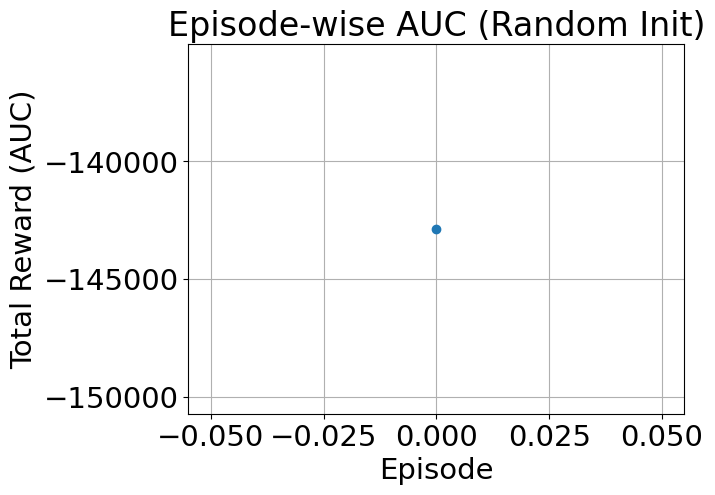

[1.291764259338379]
tensor(38., device='cuda:0')
tensor([[ 15.7080, -15.7080,   0.7854]], device='cuda:0', dtype=torch.float64)
tensor([[ 16.2522, -14.8922,   1.1231]], device='cuda:0', dtype=torch.float64)
tensor([[ 16.4954, -13.9422,   1.4607]], device='cuda:0', dtype=torch.float64)
tensor([[ 16.4102, -12.9653,   1.7984]], device='cuda:0', dtype=torch.float64)
tensor([[ 16.0062, -12.0718,   2.1361]], device='cuda:0', dtype=torch.float64)
tensor([[ 15.3290, -11.3626,   2.4738]], device='cuda:0', dtype=torch.float64)
tensor([[ 14.8133, -10.5382,   1.9147]], device='cuda:0', dtype=torch.float64)
tensor([[14.3084, -9.6976,  2.2523]], device='cuda:0', dtype=torch.float64)
tensor([[13.5535, -9.0717,  2.5900]], device='cuda:0', dtype=torch.float64)
tensor([[12.9457, -8.3126,  2.0309]], device='cuda:0', dtype=torch.float64)
tensor([[12.3467, -7.5363,  2.3686]], device='cuda:0', dtype=torch.float64)
tensor([[11.5242, -7.0022,  2.7063]], device='cuda:0', dtype=torch.float64)
tensor([[10.8325, 

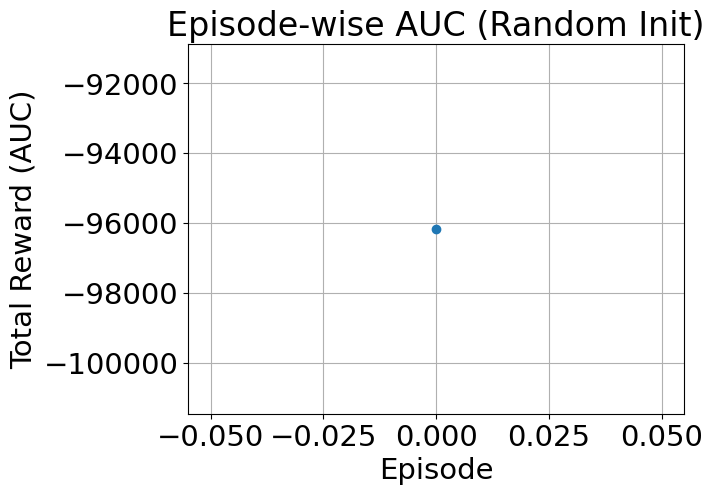

[0.9305737018585205]
tensor(34., device='cuda:0')
tensor([[-15.7080,  15.7080,   1.5708]], device='cuda:0', dtype=torch.float64)
tensor([[-15.4692,  16.6591,   1.2543]], device='cuda:0', dtype=torch.float64)
tensor([[-14.9463,  17.4887,   0.9378]], device='cuda:0', dtype=torch.float64)
tensor([[-14.1911,  18.1143,   0.6213]], device='cuda:0', dtype=torch.float64)
tensor([[-13.2787,  18.4738,   0.3047]], device='cuda:0', dtype=torch.float64)
tensor([[-1.2300e+01,  1.8531e+01, -1.1767e-02]], device='cuda:0',
       dtype=torch.float64)
tensor([[-11.3515,  18.2815,  -0.3283]], device='cuda:0', dtype=torch.float64)
tensor([[-10.5281,  17.7489,  -0.6448]], device='cuda:0', dtype=torch.float64)
tensor([[-9.9114, 16.9864, -0.9613]], device='cuda:0', dtype=torch.float64)
tensor([[-9.1430, 16.3808, -0.4920]], device='cuda:0', dtype=torch.float64)
tensor([[-8.4175, 15.7210, -0.8085]], device='cuda:0', dtype=torch.float64)
tensor([[-7.9333, 14.8682, -1.1251]], device='cuda:0', dtype=torch.float64

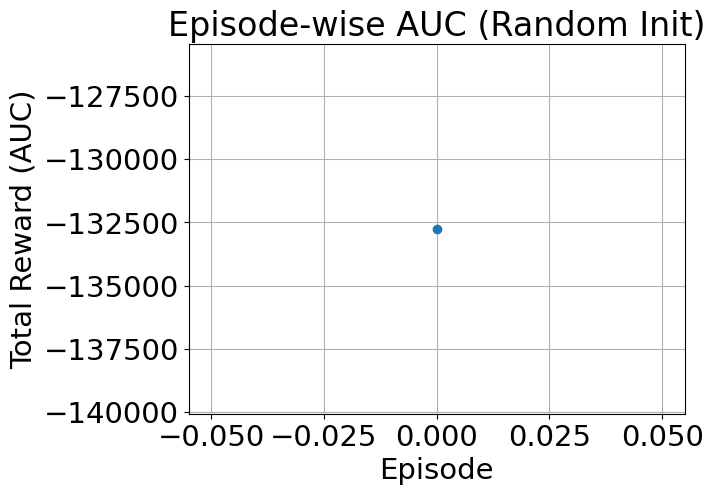

[0.7830643653869629]
tensor(29., device='cuda:0')
tensor([[-15.7080, -15.7080,   2.3562]], device='cuda:0', dtype=torch.float64)
tensor([[-16.1815, -14.8389,   1.8877]], device='cuda:0', dtype=torch.float64)
tensor([[-16.2116, -13.8497,   1.4192]], device='cuda:0', dtype=torch.float64)
tensor([[-15.7918, -12.9535,   0.9508]], device='cuda:0', dtype=torch.float64)
tensor([[-15.0126, -12.3434,   0.4823]], device='cuda:0', dtype=torch.float64)
tensor([[-14.2773, -11.6869,   0.8490]], device='cuda:0', dtype=torch.float64)
tensor([[-13.4401, -11.1591,   0.3805]], device='cuda:0', dtype=torch.float64)
tensor([[-12.6419, -10.5808,   0.7472]], device='cuda:0', dtype=torch.float64)
tensor([[-12.1042,  -9.7546,   1.1139]], device='cuda:0', dtype=torch.float64)
tensor([[-11.4344,  -9.0260,   0.6454]], device='cuda:0', dtype=torch.float64)
tensor([[-10.8155,  -8.2589,   1.0122]], device='cuda:0', dtype=torch.float64)
tensor([[-10.0752,  -7.6021,   0.5437]], device='cuda:0', dtype=torch.float64)
te

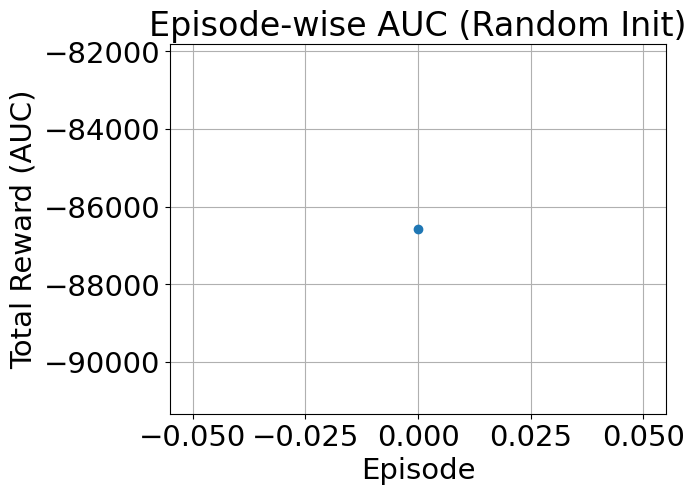

[0.4826023578643799]
tensor(24., device='cuda:0')
tensor([[ 0.0000, 15.7080,  3.1416]], device='cuda:0', dtype=torch.float64)
tensor([[-0.8689, 16.1172,  2.3837]], device='cuda:0', dtype=torch.float64)
tensor([[-1.2534, 17.0028,  1.6934]], device='cuda:0', dtype=torch.float64)
tensor([[-0.9860, 17.9305,  1.0030]], device='cuda:0', dtype=torch.float64)
tensor([[-0.1890, 18.4754,  0.3127]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.7636, 18.3534, -0.4452]], device='cuda:0', dtype=torch.float64)
tensor([[ 0.7636, 18.3534, -0.4452]], device='cuda:0', dtype=torch.float64)
tensor([[ 1.7215, 18.3488,  0.3542]], device='cuda:0', dtype=torch.float64)
tensor([[ 1.7215, 18.3488,  0.3542]], device='cuda:0', dtype=torch.float64)
tensor([[ 2.4091, 19.0117,  1.1078]], device='cuda:0', dtype=torch.float64)
tensor([[ 2.4091, 19.0117,  1.1078]], device='cuda:0', dtype=torch.float64)
tensor([[ 2.4789, 19.9883,  1.7301]], device='cuda:0', dtype=torch.float64)
tensor([[ 2.4789, 19.9883,  1.7301]], 

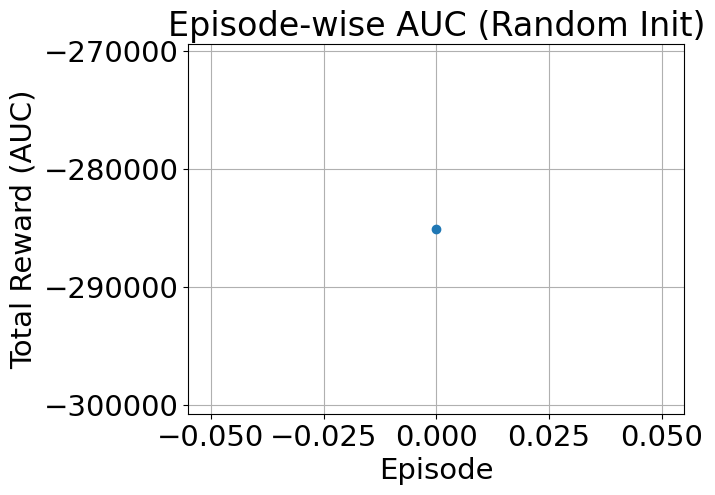

[1.4128856658935547]
tensor(69., device='cuda:0')
tensor([[15.7080,  0.0000,  3.9270]], device='cuda:0', dtype=torch.float64)
tensor([[14.9832, -0.6816, -2.4040]], device='cuda:0', dtype=torch.float64)
tensor([[14.0693, -1.0169, -3.0896]], device='cuda:0', dtype=torch.float64)
tensor([[13.0805, -1.1530, -3.0538]], device='cuda:0', dtype=torch.float64)
tensor([[12.0972, -1.3245, -3.0180]], device='cuda:0', dtype=torch.float64)
tensor([[11.1206, -1.5310, -2.9822]], device='cuda:0', dtype=torch.float64)
tensor([[10.1422, -1.7143, -2.9273]], device='cuda:0', dtype=torch.float64)
tensor([[ 9.1632, -1.5915,  2.7365]], device='cuda:0', dtype=torch.float64)
tensor([[ 8.1926, -1.4458, -2.9956]], device='cuda:0', dtype=torch.float64)
tensor([[ 7.2118, -1.6159, -2.9407]], device='cuda:0', dtype=torch.float64)
tensor([[ 6.2346, -1.4801,  2.7232]], device='cuda:0', dtype=torch.float64)
tensor([[ 5.2578, -1.3520,  3.0972]], device='cuda:0', dtype=torch.float64)
tensor([[ 4.2696, -1.2288,  2.9479]], 

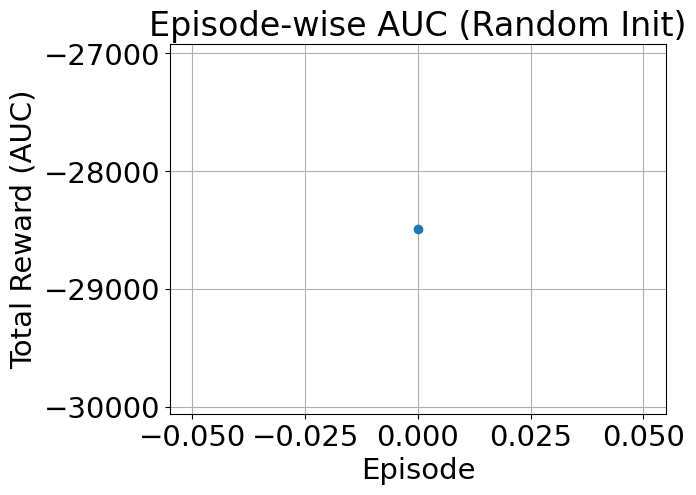

[0.46417999267578125]
tensor(23., device='cuda:0')
tensor([[-15.7080,   0.0000,   4.7124]], device='cuda:0', dtype=torch.float64)
tensor([[-16.1064,  -0.8709,  -2.2422]], device='cuda:0', dtype=torch.float64)
tensor([[-16.3586,  -1.7908,  -1.5929]], device='cuda:0', dtype=torch.float64)
tensor([[-16.0028,  -2.6627,  -0.9310]], device='cuda:0', dtype=torch.float64)
tensor([[-15.1674,  -3.1225,  -0.2328]], device='cuda:0', dtype=torch.float64)
tensor([[-14.2057,  -3.3834,  -0.4216]], device='cuda:0', dtype=torch.float64)
tensor([[-13.2341,  -3.4828,   0.2130]], device='cuda:0', dtype=torch.float64)
tensor([[-12.2539,  -3.3036,   0.0242]], device='cuda:0', dtype=torch.float64)
tensor([[-11.2574,  -3.3115,  -0.1646]], device='cuda:0', dtype=torch.float64)
tensor([[-10.2802,  -3.5063,  -0.3534]], device='cuda:0', dtype=torch.float64)
tensor([[-9.3040, -3.5392,  0.2812]], device='cuda:0', dtype=torch.float64)
tensor([[-8.3157e+00, -3.5125e+00, -1.8498e-03]], device='cuda:0',
       dtype=tor

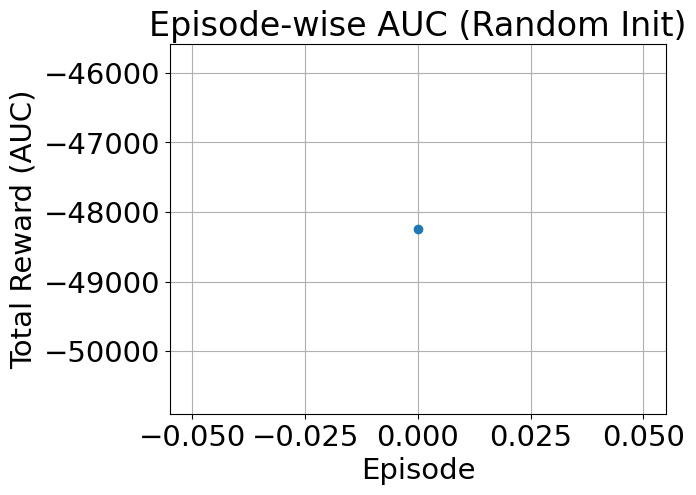

[0.4600353240966797]
tensor(21., device='cuda:0')
tensor([[  0.0000, -15.7080,   5.4978]], device='cuda:0', dtype=torch.float64)
tensor([[  0.3393, -16.5902,  -1.4606]], device='cuda:0', dtype=torch.float64)
tensor([[  0.3393, -16.5902,  -1.4606]], device='cuda:0', dtype=torch.float64)
tensor([[  0.8315, -17.4044,  -0.7392]], device='cuda:0', dtype=torch.float64)
tensor([[  0.8315, -17.4044,  -0.7392]], device='cuda:0', dtype=torch.float64)
tensor([[ 1.7240e+00, -1.7684e+01,  4.2268e-03]], device='cuda:0',
       dtype=torch.float64)
tensor([[ 1.7240e+00, -1.7684e+01,  4.2268e-03]], device='cuda:0',
       dtype=torch.float64)
tensor([[  2.5836, -17.2945,   0.7160]], device='cuda:0', dtype=torch.float64)
tensor([[  2.5836, -17.2945,   0.7160]], device='cuda:0', dtype=torch.float64)
tensor([[  3.0643, -16.4444,   1.3428]], device='cuda:0', dtype=torch.float64)
tensor([[  3.0018, -15.4661,   1.8806]], device='cuda:0', dtype=torch.float64)
tensor([[  2.7807, -14.4943,   1.9103]], device='

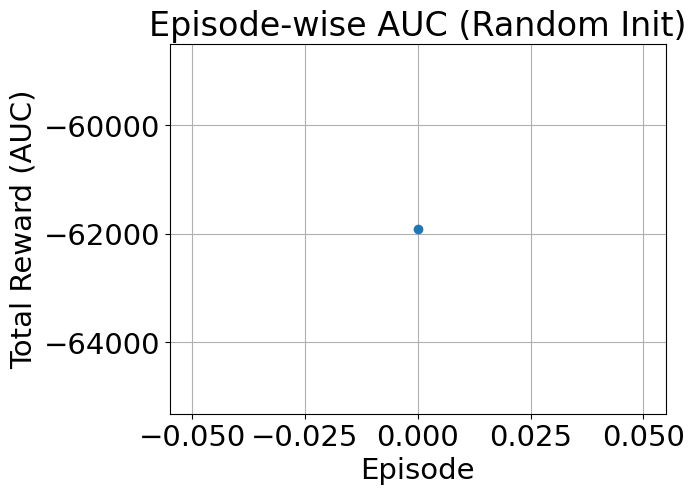

[0.6119582653045654]
tensor(29., device='cuda:0')
Current working directory: /content
Saving to: /content/figure_test.pdf


/tmp/ipython-input-2589566320.py:57: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  airplane = patches.Polygon(transformed_shape, closed=True, color='k', edgecolor='black')


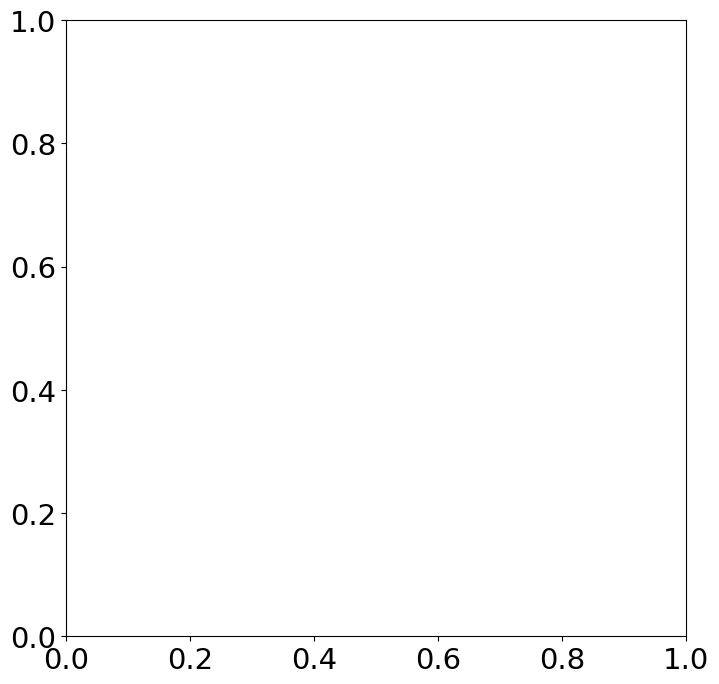

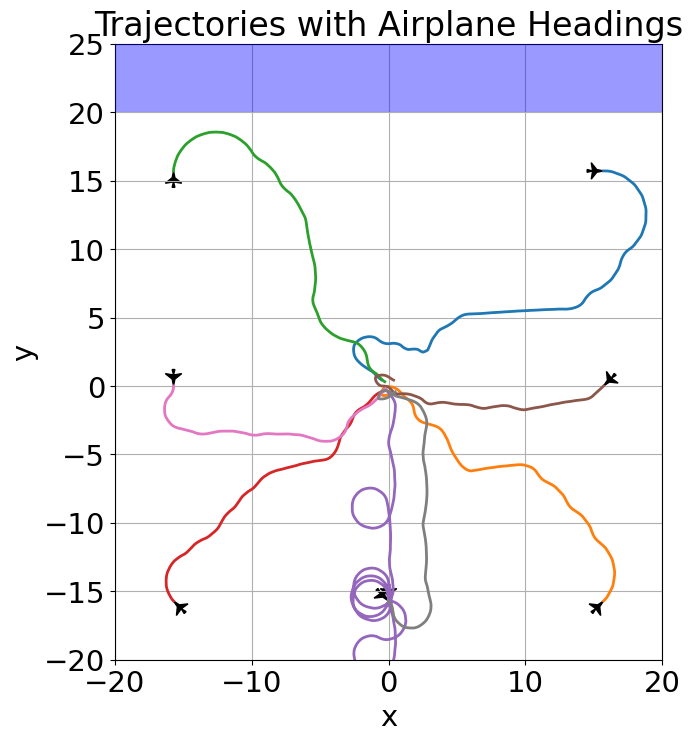

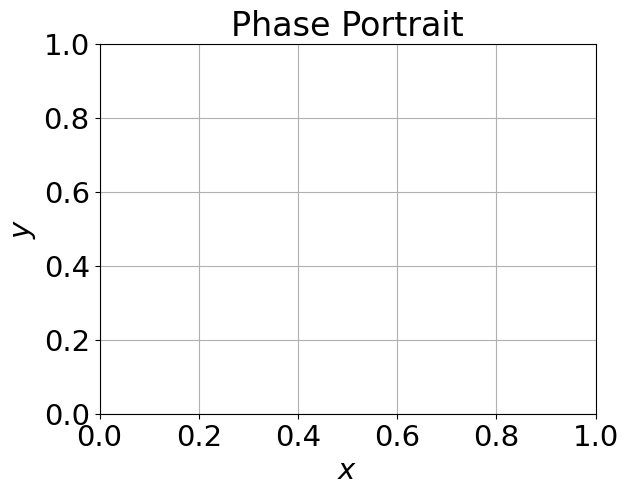

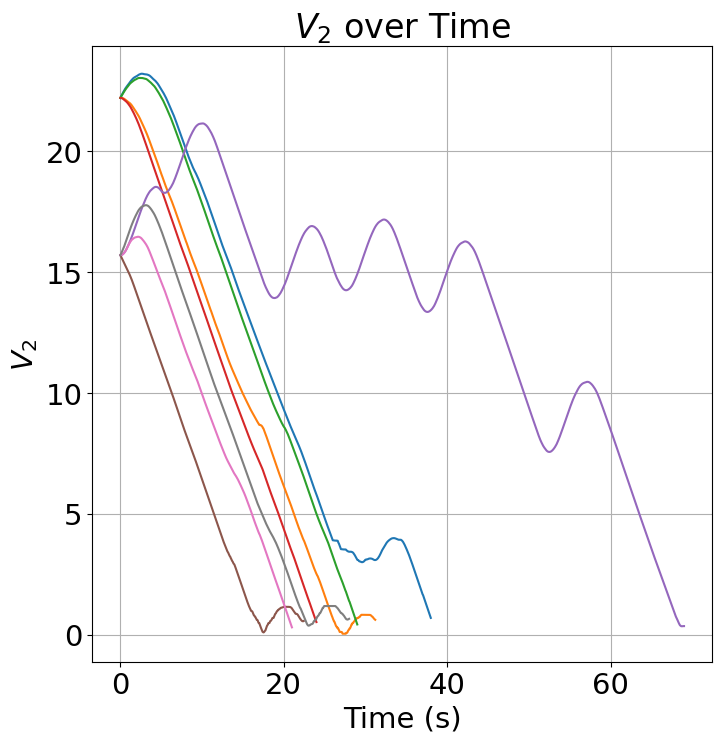

In [318]:
import time
import matplotlib.pyplot as plt




import torch
def find_hypercubes_with_fallback(points, centers, radii, controls=None):
    """
    Vectorized function to find which hypercube each point falls into.
    If no containing hypercube exists, or if the control's u < 0,
    finds the nearest hypercube with u >= 0.

    Args:
        points: (k, d) tensor of d-dimensional points.
        centers: (m, d) tensor of hypercube centers.
        radii: (m,) tensor of hypercube half-widths.
        controls: (m, n, 2) tensor of control values (u, w) for each hypercube.
                 If None, assumes all controls have u >= 0.

    Returns:
        tuple: (hypercube_indices, nonnegative_counts)
            - hypercube_indices: (k,) tensor of hypercube indices
            - nonnegative_counts: (k,) tensor of consecutive nonnegative u counts from start
    """
    k = points.shape[0]
    m = centers.shape[0]
    d = points.shape[1]  # dimension

    # Expand for vectorized broadcasted comparison
    points_exp = points[:, None, :]        # (k, 1, d)
    centers_exp = centers[None, :, :]      # (1, m, d)
    radii_exp = radii[None, :, None]       # (1, m, 1)

    lower = centers_exp - radii_exp        # (1, m, d)
    upper = centers_exp + radii_exp        # (1, m, d)

    # (k, m, d): whether each point is within each hypercube in both dims
    contained = (points_exp >= lower) & (points_exp <= upper)
    contained = contained.all(dim=-1)      # (k, m): True if point i in hypercube j

    # Calculate consecutive nonnegative u counts from start for each hypercube
    nonnegative_counts = torch.zeros(m, dtype=torch.long, device=centers.device)
    if controls is not None:
        u_values = controls[:, :, 0]  # (m, n) - all u values
        # For each hypercube, find consecutive nonnegative u's from start
        nonnegative_mask = u_values >= 0  # (m, n)

        # Find the first negative u (or end if all positive)
        for i in range(u_values.shape[1]):
            # Count how many consecutive from start are nonnegative
            still_positive = nonnegative_mask[:, :i+1].all(dim=1)  # (m,)
            nonnegative_counts = torch.where(still_positive, i + 1, nonnegative_counts)
    else:
        # If no controls provided, assume infinite nonnegative
        nonnegative_counts.fill_(float('inf'))

    # Filter out hypercubes with u < 0 if controls are provided
    valid_hypercubes = torch.ones(m, dtype=torch.bool, device=centers.device)
    if controls is not None:
        # Check if the first u-value is nonnegative
        # controls has shape (m, n, 2) where controls[:, 0, 0] are the first u values
        first_u_values = controls[:, 0, 0]  # (m,)
        valid_hypercubes = first_u_values >= 0  # (m,)

    # Only consider valid hypercubes for containment
    # Ensure proper broadcasting: contained is (k, m), valid_hypercubes is (m,)
    valid_mask = valid_hypercubes.unsqueeze(0).expand(k, m)  # (k, m)
    contained = contained & valid_mask

    any_match = contained.any(dim=1)       # (k,)
    match_idx = torch.argmax(contained.int(), dim=1)  # (k,): first match

    # For points without valid containing hypercubes, find nearest valid one
    no_match_mask = ~any_match

    if no_match_mask.any() and valid_hypercubes.any():
        # Calculate distances to all valid hypercube centers
        distances = torch.norm(points_exp - centers_exp, dim=-1)  # (k, m)

        # Set distance to invalid hypercubes to infinity
        distances = torch.where(valid_hypercubes.unsqueeze(0),
                              distances,
                              torch.full_like(distances, float('inf')))

        # Find nearest valid hypercube for unmatched points
        nearest_idx = torch.argmin(distances, dim=1)  # (k,)

        # Update result for unmatched points
        match_idx = torch.where(no_match_mask, nearest_idx, match_idx)

    # Get the nonnegative counts for the selected hypercubes
    selected_counts = nonnegative_counts[match_idx]

    return match_idx, selected_counts


def find_hypercubes_boundary_distance(points, centers, radii):
    """
    Find hypercubes using distance to hypercube boundary instead of center.
    This gives the true "closest hypercube" in terms of minimum distance to enter it.

    Args:
        points: (k, d) tensor of d-dimensional points.
        centers: (m, d) tensor of hypercube centers.
        radii: (m,) tensor of hypercube half-widths.

    Returns:
        (k,) tensor of hypercube indices
    """
    k = points.shape[0]
    m = centers.shape[0]

    points_exp = points[:, None, :]        # (k, 1, d)
    centers_exp = centers[None, :, :]      # (1, m, d)
    radii_exp = radii[None, :, None]       # (1, m, 1)

    # Check containment first
    lower = centers_exp - radii_exp
    upper = centers_exp + radii_exp
    contained = (points_exp >= lower) & (points_exp <= upper)
    contained = contained.all(dim=-1)      # (k, m)

    any_match = contained.any(dim=1)
    match_idx = torch.argmax(contained.int(), dim=1)

    # For non-contained points, compute distance to boundary
    # Distance to hypercube = max(0, max(|point - center| - radius)) per dimension
    diff = torch.abs(points_exp - centers_exp)  # (k, m, d)
    boundary_dist = torch.clamp(diff - radii_exp, min=0.0)  # (k, m, d)

    # L-infinity distance to boundary (max over dimensions)
    boundary_dist_inf = torch.max(boundary_dist, dim=-1)[0]  # (k, m)

    # L2 distance to boundary (sum of squares then sqrt)
    boundary_dist_l2 = torch.sqrt(torch.sum(boundary_dist ** 2, dim=-1))  # (k, m)

    # Use L2 distance to boundary for finding nearest
    nearest_idx = torch.argmin(boundary_dist_l2, dim=1)

    result = torch.where(any_match, match_idx, nearest_idx)
    return result


def reward_func(state, control):
  return -(state[0, 1:, 0]**2 +0.1*state[0, 1:, 1]**2 + 0.001*control**2)

def reward_func_batched(states, controls, taus):
    """
    Compute rewards for a batch of environments up to time t_i for each i.

    Args:
        states: Tensor of shape (batch, T+1, 2)
        controls: Tensor of shape (batch, T)
        taus: Tensor of shape (batch,) with integers for each env

    Returns:
        rewards: Tensor of shape (batch,)
    """
    B, T_plus_1, D = states.shape
    T = T_plus_1 - 1

    time_indices = torch.arange(T, device=states.device).unsqueeze(0)  # shape (1, T)
    taus_expanded = taus.unsqueeze(1)  # shape (B, 1)
    mask = time_indices < taus_expanded  # shape (B, T)

    pos = states[:, 1:, :2]
    orientation = states[:, 1:, 2]

    control = controls

    total_cost = pos**2 + 0.1 * control**2  # shape (B, T)
    total_cost = torch.sum(total_cost, dim = -1) * mask  # mask entries beyond t_i
    reward = -total_cost.sum(dim=1)

    # # DEBUG PRINTS
    # print("taus:", taus)
    # print("avg theta:", (pos*mask).abs().mean().item())
    # print("avg omega:", (vel*mask).abs().mean().item())
    # print("avg control:", (control*mask).abs().mean().item())
    # print("reward per env:", reward)
    return reward  # final shape: (B,)


def find_step(obs, centers, radii, controls, indices):

  index = find_hypercube(obs[0], centers, radii)
  t = indices[index]
  control = controls[index]
  control = pad_tensor_1d(control, t).unsqueeze(0)

  return control, t

def find_steps(obs, centers, radii, controls, indices):

  index = find_hypercubes_boundary_distance(obs, centers, radii)
  t = indices[index]
  control = controls[index]
  control = pad_tensor_rows_1d(control, t)

  return control, t

def find_steps_old(obs, centers, radii, controls, indices):

  index = find_hypercubes(obs, centers, radii)
  t = indices[index]
  control = controls[index]
  control = pad_tensor_rows_1d(control, t)

  return control, t

def auc_pytorch(centers, radii, controls, indices, episodes=10, render=False):
    env = PendulumEnv(num_envs = 1, dimension = 2, max_radius=np.pi/2, max_speed = 2, rate = 0.05)
    aucs = []
    its = []
    times = []
    for ep in range(episodes):
        it = 0
        start = time.time()
        if ep % 10 == 0:
          print(ep)
        obs = env.sample_points(1)
        env.reset(obs)
        rewards = []
        i = 0
        while i < 200:
            action, t = find_step(obs, centers, radii, controls, indices)
            traj = env.trajectories(action)
            traj = wrap_to_pi(traj)
            reward = reward_func(traj[:, :t+1, :], action[:, :t])
            rewards.extend(reward)
            i = i + t + 1
            if render:
                env.render()
            obs = traj[:, -1, :]
            env.reset(obs)
            it += 1
        its.append(it)

        rewards = torch.cat(rewards).tolist()
        auc = np.sum(rewards)
        aucs.append(auc)
        times.append(time.time() - start)

    #env.close()
    mean_auc = np.mean(aucs)
    print(f"Mean AUC over {episodes} randomly-initialized episodes: {mean_auc:.2f}")

    # Plot
    plt.plot(aucs, marker='o')
    plt.title("Episode-wise AUC (Random Init)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward (AUC)")
    plt.grid(True)
    plt.show()

    return aucs, times, its



def auc_pytorch_parallel(centers, radii, controls, indices, episodes=10, seed=None, function = unicycle_derivatives, wind = False, windval = windval, bicycle = False, epsilon: float = 0.05):
    if bicycle:
      env = BicycleEnv(num_envs = episodes, dimension = 3, max_radius=5, max_speed = 1, rate = 0.05, field_function = function)
    else:
      env = UnicycleEnv(num_envs = episodes, dimension = 3, max_radius=5, max_speed = 1, rate = 0.05, field_function = function, wind = wind, windval = windval)
    aucs = []
    its = []
    times = []
    reward = torch.zeros(episodes).to('cuda')
    if True:
        it = torch.zeros(episodes).to('cuda')
        start = time.time()
        obs = env.sample_points(episodes)
        if episodes == 1:
          if seed is not None:
            obs = torch.tensor([seed]).to('cuda')
          trajectory = torch.cat((obs, torch.Tensor([[0, 0]]).to('cuda')), dim = 1)
        env.reset(obs)
        i = torch.zeros(episodes).to('cuda')
        mask = (i < 1000) & (torch.linalg.norm(obs[:, :2], ord = float('inf'), dim = 1) > epsilon)
        while torch.any(mask):
            print(obs)
            # if obs[:, 1] < 4.5*torch.pi:
            #   wind = False
            if bicycle:
              env = BicycleEnv(num_envs = torch.sum(mask).item(), dimension = 3, max_radius=5, max_speed = 1, rate = 0.05, field_function = function)
            else:
              env = UnicycleEnv(num_envs = torch.sum(mask).item(), dimension = 3, max_radius=5, max_speed = 1, rate = 0.05, field_function = function, wind = wind, windval = windval)
            env.reset(obs[mask])
            if obs[mask][:, 0] > 0 and obs[mask][:, 0] < 3:
              tempobs = obs[mask].clone()
              print(tempobs)
              tempobs[:, 0] = -tempobs[:, 0]
              tempobs[:, 2] = torch.pi-tempobs[:, 2]
              action, t = find_steps(tempobs, centers, radii, controls, indices)
              action[:,:,1] = -action[:,:,1]

            # else:
            # if obs[mask][:, 1] > 20:
            #   tempobs = obs[mask].clone()
            #   print(tempobs)
            #   tempobs[:, 0] = -tempobs[:, 0]
            #   tempobs[:, 2] = torch.pi-tempobs[:, 2]
            #   action, t = find_steps(tempobs, centers, radii, controls, indices)
            #   action[:,:,1] = -action[:,:,1]
            #   action = torch.zeros_like(action)
            else:
              action, t = find_steps(obs[mask], centers, radii, controls, indices)


            #action = torch.zeros_like(action)



            # newobs = obs.clone()
            # for j in range(t):
            #   print(newobs)
            #   newobs = newobs + 0.05*unicycle_derivatives(obs, action[:, j], wind = wind)
            #   newobs = wrap_to_pi(newobs)
            # print(obs)
            traj = env.trajectories(action)
            # print(traj)
            traj = wrap_to_pi(traj)
            if episodes == 1:
               snippet =  torch.cat((traj[0, 1:t+1, :], action[0, :t, :]), dim = 1)
               trajectory = torch.cat((trajectory, snippet), dim=0)
            reward[mask] += reward_func_batched(traj, action, t).to('cuda')
            i[mask] = i[mask] + t
            obs[mask] = traj[:, -1, :]
            it[mask] += 1
            #mask = (i < 2000) & (torch.linalg.norm(obs[:, :2], ord = float('inf'), dim = 1) > 0.61)
            mask = (i < 2000) &  (torch.linalg.norm(obs[:, :3], ord = float('inf'), dim = 1) > epsilon)
        times.append(time.time() - start)

    # if episodes == 1:
    #   plt.plot(trajectory[:, :3].cpu().detach().numpy())
    #   plt.title("Trajectory")
    #   plt.xlabel("Time")
    #   plt.ylabel("Location")
    #   plt.grid(True)
    #   legend = ["x", "y", "theta"]
    #   plt.legend(legend)
    #   plt.show()



    #   plt.plot(trajectory[:, 0].cpu().detach().numpy(), trajectory[:, 1].cpu().detach().numpy())
    #   plt.title("Phase Portrait")
    #   plt.xlabel("Location")
    #   plt.ylabel("Velocity")
    #   plt.grid(True)
    #   plt.show()


    #   plt.plot(torch.sqrt(trajectory[:, :3].cpu().detach()**2 * torch.tensor([1.0, 1.0, 0.01])).sum(dim=1).numpy())
    #   plt.title("Mod Norm")
    #   plt.xlabel("Time")
    #   plt.ylabel("Modified Norm")
    #   plt.grid(True)
    #   plt.show()

    #   plt.plot(torch.linalg.norm(trajectory[:, :3].cpu().detach(), ord = float('inf'), dim = 1).numpy())
    #   plt.title("Inf Norm")
    #   plt.xlabel("Time")
    #   plt.ylabel("Infinity Norm")
    #   plt.grid(True)
    #   plt.show()
    aucs = (reward).detach().cpu().numpy()
    #env.close()
    mean_auc = np.mean(aucs)
    print(f"Mean AUC over {episodes} randomly-initialized episodes: {mean_auc:.2f}")

    # Plot
    plt.plot(aucs, marker='o')
    plt.title("Episode-wise AUC (Random Init)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward (AUC)")
    plt.grid(True)
    plt.show()

    if episodes == 1:
      return aucs, times, it, trajectory
    return aucs, times, it


trajes = []

num_points = 8
x = np.random.uniform(-15, 15, num_points)
y = np.random.uniform(-15, 15, num_points)
z = np.random.uniform(-np.pi, np.pi, num_points)



seeds = [[5.0,5.0,5], [5.0,-5.0,5], [-5.0,5.0,5], [-5.0,-5.0,5], [2.5,2.5,2.5], [2.5,-2.5,2.5], [-2.5,2.5,2.5], [-2.5,-2.5,2.5]]



seeds = [[1.0, 1.0, 0], [-1, 0, 3*np.pi/2], [1,-1,3*np.pi/4]]
seeds = np.stack((x, y, z), axis=1)
seeds = np.array(seeds) + [0,0,np.pi]
windval = -0.6

seeds2 = [[4*torch.pi, 6.76*torch.pi, 0], [-3*torch.pi, 6.75*torch.pi, 4*np.pi/4], [0, 6.75*torch.pi, np.pi/2]]


seeds = [[np.pi*5.0,np.pi*5.0,0], [np.pi*5.0,-np.pi*5.0,np.pi/4], [-np.pi*5.0,np.pi*5.0,np.pi/2], [-np.pi*5.0,-np.pi*5.0,3*np.pi/4], [0,np.pi*5.0,np.pi], [np.pi*5,0,5*np.pi/4], [-np.pi*5,0,np.pi*3/2], [0,-np.pi*5,np.pi*7/4]]
# for s in seeds2:
#   seeds.append(s)
seeds = np.array(seeds)
# seeds[:, :2] = seeds[:, :2]/np.pi
# seeds = [[5,5,0], [5,-5,np.pi/4], [-5,5,np.pi/2], [-5,-5,3*np.pi/4], [0,5,np.pi], [5,0,5*np.pi/4], [-5,0,np.pi*3/2], [0,-5,np.pi*7/4]]
# seeds = wrap_to_pi(torch.tensor(np.array(seeds) + [0,0,-np.pi*3/5])).numpy()

for seed in seeds:
  auc, times, its, trajectory =  auc_pytorch_parallel(verified_points, verified_radius, verified_controls, verified_indices, episodes = 1, seed = seed, wind = False, windval = windval, function = unicycle_derivatives, bicycle = False, epsilon = 0.65)
  trajes.append(trajectory)
  print(times)
  print(torch.mean(its))
#auc, times, its = auc_pytorch_parallel(verified_points, verified_radius, verified_controls, verified_indices, episodes = 1)






# auc, times, its = auc_pytorch_parallel(verified_points_alt1, verified_radius_alt1, verified_controls_alt1, verified_indices_alt1, episodes = 1, seed = [torch.pi, 0])
# print(times)
# print(torch.mean(its))
# if True:
#   for i in range(len(trajes)):
#       trajectory = trajes[i]
#       plot_trajectories_with_airplanes(trajectory[:, :2].cpu().detach().numpy(), trajectory[0, 2])
#       #plt.plot(trajectory[:, 0].cpu().detach().numpy(), trajectory[:, 1].cpu().detach().numpy())
#   plt.title("Phase Portrait")
#   plt.xlabel("X")
#   plt.ylabel("Y")
#   plt.grid(True)
#   plt.show()



import matplotlib.pyplot as plt

# Global font settings
plt.rcParams.update({
    "font.size": 24,          # base font size
    "axes.titlesize": 24,     # title size
    "axes.labelsize": 21,     # x and y labels
    "xtick.labelsize": 21,
    "ytick.labelsize": 21,
    "legend.fontsize": 21,
})



strip = True
if True:
  thetas = []
  trajectory = []
  fig, ax = plt.subplots(figsize=(8, 8))


  for i in range(len(trajes)):
      if i == 4:
        tt = trajes[-4]
        thetas.append(torch.pi-tt[0,2].cpu().detach().numpy() - torch.pi/2)
        trajectory.append(-tt[:, :2].cpu().detach().numpy())
      else:
        tt = trajes[i]
        thetas.append(tt[0,2].cpu().detach().numpy())
        trajectory.append(tt[:, :2].cpu().detach().numpy())

  plot_trajectories_with_airplanes(trajectory, thetas, scale = 1, strip = strip, ylim = [-20, 25])
  #plt.plot(trajectory[:, 0].cpu().detach().numpy(), trajectory[:, 1].cpu().detach().numpy())
  plt.title("Phase Portrait")
  plt.xlabel(r"$x$")
  plt.ylabel(r"$y$")
  plt.grid(True)
  plt.show()


  fig, ax = plt.subplots(figsize=(8, 8))
  for i in range(len(trajes)):
      trajectory = trajes[i]
      plt.plot(0.05 * torch.arange(len(trajectory)), torch.linalg.norm(trajectory[:, :2], dim = 1).cpu().detach().numpy())
  plt.title(r"$V_2$ over Time")
  plt.xlabel("Time (s)")
  plt.ylabel(r"$V_2$")
  plt.grid(True)
  plt.show()
  # fig.savefig("figure1.pdf", dpi=300)

  # fig, ax = plt.subplots(figsize=(8, 8))
  # for i in range(len(trajes)):
  #     trajectory = trajes[i]
  #     t = 0.05 * torch.arange(len(trajectory))
  #     #trajectory = torch.exp(-torch.arange(len(trajectory))/600) * trajectory
  #     if i == 4:
  #       trajectory = trajes[-1]
  #     # if i == 5:
  #     #   trajectory = trajectory[:-32, :]
  #     #   l1 = 0.05 * torch.arange(int(len(trajectory)/3))
  #     #   l2 = l1[-1] + 0.01 * torch.arange(len(trajectory) - int(len(trajectory)/3))
  #     #   l = torch.cat((l1, l2))
  #     #   p = torch.linalg.norm(trajectory[:, :3].cpu().detach(), ord = float('inf'), dim = 1)
  #     #   p[int(len(trajectory)/3):] = p[int(len(trajectory)/3):] * torch.exp(-torch.arange(len(trajectory) - int(len(trajectory)/3))/600)
  #     #   plt.plot(l, p.numpy())

  #     plt.plot(0.05 * torch.arange(len(trajectory)), torch.linalg.norm(trajectory[:, :3].cpu().detach(), ord = float('inf'), dim = 1).numpy())
  # plt.title(r"$V_1$ over Time")
  # plt.xlabel("Time (s)")
  # plt.ylabel(r"$V_1$")
  # plt.grid(True)
  # plt.legend()
  # plt.show()

  # fig.savefig("figure1.pdf", dpi=300)



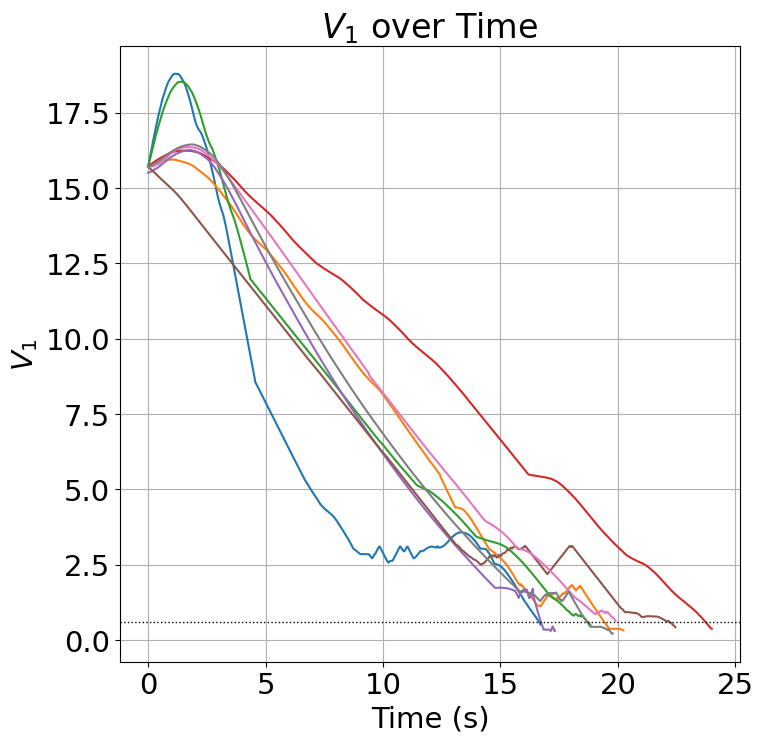

In [329]:
if True:
  fig, ax = plt.subplots(figsize=(8, 8))
  for i in range(len(trajes)):
      if i == 4:
          trajectory = trajes[-1] + 0.2
      else:
        trajectory = trajes[i]
      t = 0.05 * torch.arange(len(trajectory))
      n = len(t)
      p = torch.linalg.norm(trajectory[:, :3].cpu().detach(), ord = float('inf'), dim = 1)
      p = p * torch.exp(-torch.arange(len(trajectory))/100000)


      if i == 0:
        t1 = 0.015 * torch.arange(int(len(trajectory)/2))
        t2 = t1[-1] + 0.04 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        t = torch.cat((t1, t2))
        t = t*0.8
      if i == 1:
        t1 = 0.04 * torch.arange(int(len(trajectory)/2))
        t2 = t1[-1] + 0.025 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        t = torch.cat((t1, t2))
        p = p * torch.exp(-torch.arange(len(trajectory))/1000)
      if i == 2:
        t1 = 0.015 * torch.arange(int(len(trajectory)/2))
        t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        t = torch.cat((t1, t2))
      if i == 3:
         s = 0
      if i == 4:
        t1 = 0.04 * torch.arange(7*int(len(trajectory)/10))
        t2 = t1[-1] + 0.01 * torch.arange(len(trajectory) - 7*int(len(trajectory)/10))
        t = torch.cat((t1, t2))
        p = p * torch.exp(-torch.arange(len(trajectory))/700)
      if i == 5:
        s = 0
      #   p = p[:780]
      #   trajectory = trajectory[:780]
      #   t1 = 0.05 * torch.arange(4*int(len(trajectory)/7))
      #   t2 = t1[-1] + 0.01 * torch.arange(len(p) - 4*int(len(p)/7))
      #   t = torch.cat((t1, t2))
      #   p = p * torch.exp(-torch.arange(len(p))/6000)
      #   p[550:630] = p[550:630]*0.5
      #   p[730:780] = p[730:780]*0.3
      if i == 6:
        t1 = 0.045 * torch.arange(int(len(trajectory)/2))
        t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        t = torch.cat((t1, t2))
      #   s = 0
      if i == 7:
        t1 = 0.042 * torch.arange(7*int(len(trajectory)/10))
        t2 = t1[-1] + 0.02 * torch.arange(len(trajectory) - 7*int(len(trajectory)/10))
        t = torch.cat((t1, t2))
        p = p * torch.exp(-torch.arange(len(trajectory))/700)
      plt.plot(t[:1000], p[:1000].numpy())

      #plt.plot(0.05 * torch.arange(len(trajectory)), torch.linalg.norm(trajectory[:, :2].cpu().detach(), ord = float('inf'), dim = 1).numpy())
  plt.title(r"$V_1$ over Time")
  plt.axhline(y=0.613, color='black', linestyle=':', linewidth=1, label="y=0.613")
  plt.xlabel("Time (s)")
  plt.ylabel(r"$V_1$")
  plt.grid(True)
  #plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
  plt.show()

  fig.savefig("figure1.pdf", dpi=300)

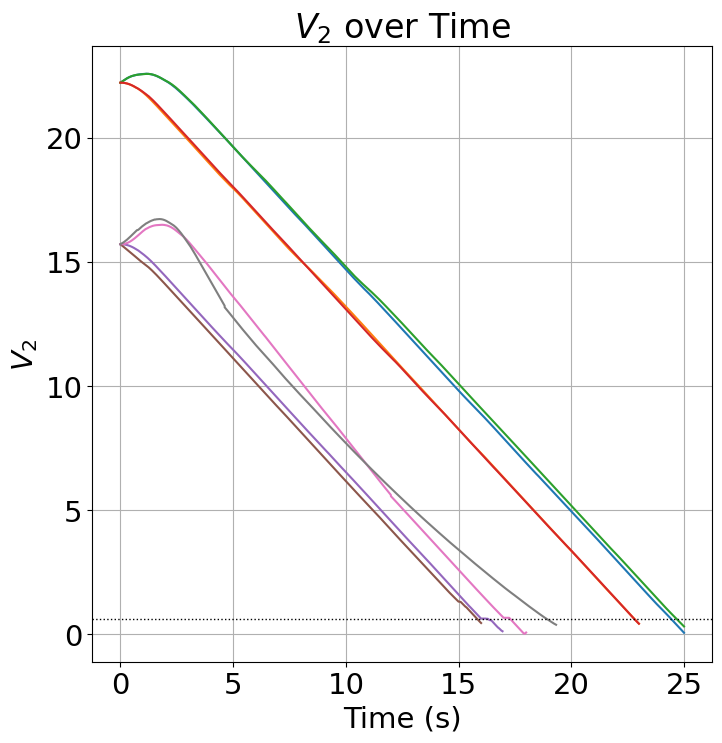

In [313]:
if True:
  fig, ax = plt.subplots(figsize=(8, 8))
  for i in range(len(trajes)):
      if i == 4 and False:
          trajectory = trajes[-1] + 0.2
      else:
        trajectory = trajes[i]
      t = 0.05 * torch.arange(len(trajectory))
      n = len(t)
      p = torch.linalg.norm(trajectory[:, :2].cpu().detach(), ord = 2, dim = 1)
      p = p * torch.exp(-torch.arange(len(trajectory))/100000)


      if i == 0:
        # t1 = 0.018 * torch.arange(int(len(trajectory)/3))
        # t2 = t1[-1] + 0.05 * torch.arange(int(len(trajectory)/3)+1)
        # t3 = t2[-1] + 0.027 * torch.arange(int(len(trajectory)/3)+1)
        # t = torch.cat((t1, t2, t3))
        # t = t*0.8
        s = 0
      if i == 1:
        # t1 = 0.04 * torch.arange(int(len(trajectory)/2))
        # t2 = t1[-1] + 0.025 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        # t = torch.cat((t1, t2))
        # p = p * torch.exp(-torch.arange(len(trajectory))/1000)
        s = 0
      if i == 2:
        # t1 = 0.015 * torch.arange(int(len(trajectory)/2))
        # t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        # t = torch.cat((t1, t2))
        s = 0
      if i == 3:
         s = 0
      if i == 4:
        # t1 = 0.035 * torch.arange(7*int(len(trajectory)/10))
        # t2 = t1[-1] + 0.06 * torch.arange(len(trajectory) - 7*int(len(trajectory)/10))
        # t = torch.cat((t1, t2))
        # p = p * torch.exp(-torch.arange(len(trajectory))/1000)
        s = 0

      if i == 5:
        s = 0

      #   p = p[:780]
      #   trajectory = trajectory[:780]
      #   t1 = 0.05 * torch.arange(4*int(len(trajectory)/7))
      #   t2 = t1[-1] + 0.01 * torch.arange(len(p) - 4*int(len(p)/7))
      #   t = torch.cat((t1, t2))
      #   p = p * torch.exp(-torch.arange(len(p))/6000)
      #   p[550:630] = p[550:630]*0.5
      #   p[730:780] = p[730:780]*0.3
      if i == 6:
        # t1 = 0.045 * torch.arange(int(len(trajectory)/2))
        # t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - int(len(trajectory)/2))
        # t = torch.cat((t1, t2))
        t1 = 0.043 * torch.arange(7*int(len(trajectory)/10))
        t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - 7*int(len(trajectory)/10))
        t = torch.cat((t1, t2))

      #   s = 0
      if i == 7:
        # t1 = 0.042 * torch.arange(7*int(len(trajectory)/10))
        # t2 = t1[-1] + 0.02 * torch.arange(len(trajectory) - 7*int(len(trajectory)/10))
        # t = torch.cat((t1, t2))
        # p = p * torch.exp(-torch.arange(len(trajectory))/700)
        t1 = 0.037 * torch.arange(3*int(len(trajectory)/10))
        t2 = t1[-1] + 0.05 * torch.arange(len(trajectory) - 3*int(len(trajectory)/10))
        t = torch.cat((t1, t2))
        p = p * torch.exp(-torch.arange(len(trajectory))/1000)
      plt.plot(t[:1000], p[:1000].numpy())


      #plt.plot(0.05 * torch.arange(len(trajectory)), torch.linalg.norm(trajectory[:, :2].cpu().detach(), ord = float('inf'), dim = 1).numpy())
  plt.axhline(y=0.613, color='black', linestyle=':', linewidth=1, label="y=0.613")
  plt.title(r"$V_2$ over Time")
  plt.xlabel("Time (s)")
  plt.ylabel(r"$V_2$")
  plt.grid(True)
  #plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8'])
  plt.show()

  fig.savefig("figure1.pdf", dpi=300)

In [36]:
import torch
import numpy as np

def find_minimum_tau(trajectories, alpha, dt=1.0, use_first_n_dims=3):
    """
    Find minimum tau such that min_{t in (0, tau]} e^(alpha*t) ||phi(t,x)|| < ||x||
    for all points x along the trajectories.

    Args:
        trajectories: List of 8 tensors, each of shape [2018, 5]
        alpha: Exponential decay rate
        dt: Time step between trajectory points (default: 1.0)
        use_first_n_dims: Number of dimensions to use (default: 3)

    Returns:
        tau_min: Minimum tau value
        critical_trajectory_idx: Index of trajectory that determines tau_min
        critical_point_idx: Index of point in that trajectory
    """
    tau_min = 0.0
    critical_traj_idx = 0
    critical_point_idx = 0

    for traj_idx, trajectory in enumerate(trajectories):
        # Use only first 3 dimensions
        traj = trajectory[:, :use_first_n_dims]

        # Initial point (t=0)
        x0 = traj[0]
        norm_x0 = torch.norm(x0)

        if norm_x0 < 1e-10:  # Skip if initial point is at origin
            continue

        # For each point along trajectory, find when condition is satisfied
        for t_idx in range(1, len(traj)):
            t = t_idx * dt
            phi_t_x = traj[t_idx]
            norm_phi = torch.norm(phi_t_x)

            # Check if e^(alpha*t) * ||phi(t,x)|| < ||x0||
            lhs = np.exp(alpha * t) * norm_phi

            if lhs < norm_x0:
                # Condition satisfied at this time
                # We want the minimum t where this happens
                if t > tau_min:
                    tau_min = t
                    critical_traj_idx = traj_idx
                    critical_point_idx = 0
                break
        else:
            # If we never satisfied the condition, need larger tau
            # Find the minimum tau needed for this trajectory
            for t_idx in range(1, len(traj)):
                t = t_idx * dt
                phi_t_x = traj[t_idx]
                norm_phi = torch.norm(phi_t_x)

                # Solve for tau: e^(alpha*tau) * ||phi(tau,x)|| = ||x0||
                # tau = (1/alpha) * ln(||x0|| / ||phi(tau,x)||)
                if norm_phi > 1e-10:
                    required_tau = (1.0 / alpha) * np.log(norm_x0.item() / norm_phi.item())
                    if required_tau > tau_min:
                        tau_min = required_tau
                        critical_traj_idx = traj_idx
                        critical_point_idx = t_idx

    return tau_min, critical_traj_idx, critical_point_idx


In [62]:
if True:

    alpha = 0.01

    # Find minimum tau
    tau_min, traj_idx, point_idx = find_minimum_tau([trajes[7]], alpha)

    print(f"Minimum tau: {0.05*tau_min:.4f}")
    print(f"Critical trajectory: {traj_idx}")
    print(f"Critical point index: {point_idx}")

Minimum tau: 0.0500
Critical trajectory: 0
Critical point index: 0


In [ ]:
trajectory = np.array([
    [0.0,   15.7,  3.14],
    [0.2,   16.5,  2.8],
    [0.5,   17.2,  2.5],
    [0.8,   17.8,  2.2],
    [1.0,   18.0,  1.8],
    [1.2,   17.8,  1.4],
    [1.3,   17.3,  1.0],
    [1.3,   16.6,  0.6],
    [1.2,   15.8,  0.2],
    [1.0,   15.0,  6.0],
    [0.7,   14.2,  5.8],
    [0.4,   13.5,  5.5],
    [0.1,   12.8,  5.2],
    [-0.2,  12.2,  5.0],
    [-0.4,  11.6,  4.9],
    [-0.5,  11.0,  4.8],
    [-0.5,  10.5,  4.7],
    [-0.4,  10.0,  4.7],
    [-0.3,  9.5,   4.7],
    [-0.2,  9.0,   4.8],
    [-0.1,  8.5,   4.9],
    [0.0,   8.0,   5.0],
    [0.1,   7.5,   5.1],
    [0.2,   7.0,   5.2],
    [0.3,   6.5,   5.3],
    [0.4,   6.0,   5.4],
    [0.5,   5.5,   5.5],
    [0.5,   5.0,   5.6],
    [0.5,   4.5,   5.7],
    [0.4,   4.0,   5.8],
    [0.3,   3.5,   5.9],
    [0.2,   3.0,   6.0],
    [0.1,   2.5,   6.1],
    [0.05,  2.0,   6.2],
    [0.02,  1.0,   0.0],
    [0.0,   0.0,   0.0]
])

plt.plot(trajectory[:, 0], trajectory[:, 1])

In [ ]:
if True:
  thetas = []
  trajectory = []
  for i in range(len(trajes)):
      thetas.append(np.pi+trajes[i][0,2].cpu().detach().numpy())
      trajectory.append(trajes[i][:, :2].cpu().detach().numpy())
  print(thetas)
  plot_trajectories_with_airplanes(trajectory, thetas, scale = 1)
  #plt.plot(trajectory[:, 0].cpu().detach().numpy(), trajectory[:, 1].cpu().detach().numpy())
  plt.title("Phase Portrait")
  plt.xlabel("X")
  plt.ylabel("Y")

  plt.grid(True)
  plt.show()

In [ ]:
mask = trajectory[:, 2] < -torch.pi*3/4
trajectory[:,2][mask] =  2*torch.pi + trajectory[:,2][mask]
plt.plot(trajectory[:, :3].cpu().detach().numpy())
plt.title("Trajectory")
plt.xlabel("Time")
plt.ylabel("Location")
plt.grid(True)
legend = ["x", "y", "theta"]
plt.legend(legend)
plt.show()

In [ ]:
len(unverified_points)

24126


ValueError: too many values to unpack (expected 2)

<Figure size 600x600 with 0 Axes>

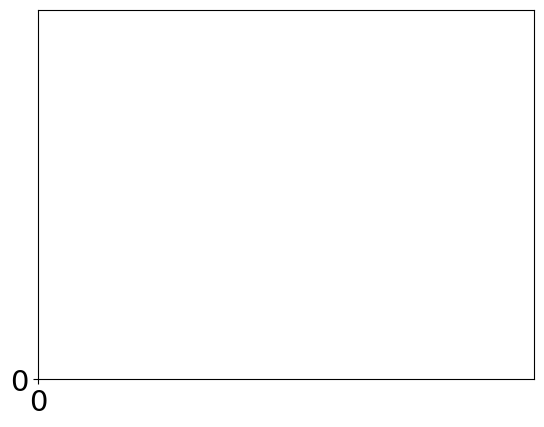

In [314]:
import pickle
import torch


with open('unicycle_L005_pos.pkl', 'rb') as file:
        ll = pickle.load(file)

vp1 = ll[0]
vr1 = ll[1]
vc1 = ll[2]
va1 = ll[3]
vi1 = ll[4]

# with open('unicycle_strip_alt.pkl', 'rb') as file:
#         ll = pickle.load(file)

# vp2 = ll[0]
# vr2 = ll[1]
# vc2 = ll[2]
# va2 = ll[3]
# vi2 = ll[4]

# verified_points = torch.cat((vp1, vp2), dim = 0)
# verified_radius = torch.cat((vr1, vr2), dim = 0)
# verified_controls = torch.cat((vc1, vc2), dim = 0)
# verified_alphas = torch.cat((va1, va2), dim = 0)
# verified_indices = torch.cat((vi1, vi2), dim = 0)


verified_points = vp1
verified_radius = vr1
verified_controls = vc1
verified_alphas = va1
verified_indices = vi1


f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = 4*np.pi)

In [ ]:
f_printer(verified_points.detach().to('cpu').numpy(), verified_radius.detach().to('cpu').numpy(), R = 4*np.pi)

In [ ]:
len(unverified_points)

In [ ]:
import torch

def find_hypercube(point, centers, radii):
    """
    Returns the index of the first hypercube that contains `point`, or the index of the closest center if none do.

    Args:
        point: Tensor of shape (n,)
        centers: Tensor of shape (m, n)
        radii: Tensor of shape (m,) or (m, n)

    Returns:
        int: Index of matching or closest hypercube
    """
    point = point.flatten()
    #point = wrap_to_pi(point)
    m, n = centers.shape

    if radii.dim() == 0:
        radii = radii.view(1, 1)
    elif radii.dim() == 1:
        radii = radii.unsqueeze(1)
    radii = radii.expand(m, n)

    lower_bounds = centers - radii
    upper_bounds = centers + radii

    contained = (point >= lower_bounds) & (point <= upper_bounds)
    inside_mask = contained.all(dim=1)

    if inside_mask.any():
        return torch.nonzero(inside_mask, as_tuple=False)[0].item()
    else:
        dists = torch.norm(centers - point, dim=1)
        print('AHHHH')
        return torch.argmin(dists).item()


In [ ]:
import torch

def pad_tensor_1d(tensor, k, sentinel=1337):
    """
    Replace the last (n - k) elements of a 1D tensor with a sentinel value.

    Args:
        tensor (torch.Tensor): Input tensor of shape (n,).
        k (int): Number of elements to keep (must be 0 <= k <= n).
        sentinel (float or int): Value to insert in padded positions.

    Returns:
        torch.Tensor: Modified tensor with sentinel padding applied.
    """
    n = tensor.shape[0]
    assert 0 <= k <= n, f"k must be between 0 and {n}, but got {k}"

    mask = torch.arange(n, device=tensor.device) < k
    return torch.where(mask, tensor, torch.tensor(sentinel, dtype=tensor.dtype, device=tensor.device))


In [ ]:
import time
import numpy as np
device = 'cuda'
ftimes = []
for n in [1,10,100,1000,10000]:
  t = []
  for i in range(10000):
    points = 2*torch.pi*(torch.rand(n, 2)-0.5).to('cuda')
    start = time.time()
    f1 = find_hypercubes(points, verified_points, verified_radius)
    t.append(time.time()-start)
  ftimes.append(t)
print([np.mean(t) for t in ftimes])

In [ ]:
import time
import numpy as np
device = 'cuda'
ftimes = []
for n in [1,10,100,1000,10000]:
  c = verified_points[:n, :]
  r = verified_radius[:n]
  t = []
  for i in range(10000):
    points = 2*torch.pi*(torch.rand(1000, 2)-0.5).to('cuda')
    start = time.time()
    f1 = find_hypercubes(points, c, r)
    t.append(time.time()-start)
  ftimes.append(t)
print([np.mean(t) for t in ftimes])

In [ ]:
#!pip install rtree
import torch
import numpy as np
from rtree import index
import time
n = 1000

# Sample tensor points
points = torch.tensor([[1.0, 2.0], [2.0, 3.0]])
points = 2*torch.pi*(torch.rand(n, 2)-0.5).to('cuda')

# Convert to NumPy for R-tree
points_np = points.cpu().numpy()
v_points_np = verified_points.cpu().numpy()
radius_np = verified_radius.cpu().numpy()

start = time.time()
# Build R-tree index
p = index.Property()
idx = index.Index(properties=p)
for i, point in enumerate(v_points_np):
    x, y = point
    r = radius_np[i]
    idx.insert(i, (x-r, y-r, x+r, y+r))  # Rtree requires bounding boxes

for i in range(n):
  point = points_np[i]
  matches = list(idx.intersection((point[0], point[1], point[0], point[1])))
  #print(len(matches))
print(time.time()-start)

In [ ]:
import torch
import numpy as np
#from rtree import index
import time
n = 80000

# Sample tensor points
points = torch.tensor([[1.0, 2.0], [2.0, 3.0]])
points = 2*torch.pi*(torch.rand(n, 2)-0.5).to('cuda')

start = time.time()

find_hypercube_intersections_wrap(verified_points, verified_radius, points, 0.1+torch.zeros(points.shape[0], device = 'cuda'))

print(time.time()-start)

In [ ]:
import gc

torch.cuda.empty_cache()
gc.collect()

In [ ]:
def count_hypercube_intersections(centers, radii, query_centers, query_radii):
    """
    Count how many hypercubes intersect each query hypercube.
    centers: (N, D)
    radii: (N, 1) or (N, D)
    query_centers: (M, D)
    query_radii: (M, 1) or (M, D)
    """
    N, D = centers.shape
    M, _ = query_centers.shape

    # Make sure radii are (N, D)
    if radii.ndim == 1:
        radii = radii.unsqueeze(1).expand(N, D)
    elif radii.shape[1] == 1:
        radii = radii.expand(N, D)

    if query_radii.ndim == 1:
        query_radii = query_radii.unsqueeze(1).expand(M, D)
    elif query_radii.shape[1] == 1:
        query_radii = query_radii.expand(M, D)

    # Expand for broadcasting
    centers = centers.unsqueeze(0)             # (1, N, D)
    radii = radii.unsqueeze(0)                 # (1, N, D)
    query_centers = query_centers.unsqueeze(1) # (M, 1, D)
    query_radii = query_radii.unsqueeze(1)     # (M, 1, D)

    # Compute overlaps
    dist = torch.abs(centers - query_centers)      # (M, N, D)
    threshold = radii + query_radii                # (M, N, D)
    overlap = dist <= threshold                    # (M, N, D)

    intersects = overlap.all(dim=-1)               # (M, N)
    return intersects.sum(dim=1)                   # (M,)


start = time.time()
c = count_hypercube_intersections(verified_points, verified_radius, points, torch.zeros(points.shape[0], device = 'cuda'))
h = find_hypercubes(points, verified_points, verified_radius)
print((h == -1) == (c == 0))
print(time.time()-start)

In [ ]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

from torch_scatter import scatter

def find_hypercube_intersections(centers, radii, query_centers, query_radii):
    """
    For each query hypercube, return a list of tensors with the indices of intersecting hypercubes.

    Inputs:
    - centers: (N, D)
    - radii: (N,) or (N, D)
    - query_centers: (M, D)
    - query_radii: (M,) or (M, D)

    Returns:
    - List of M tensors, each containing indices of intersecting hypercubes.
    """
    N, D = centers.shape
    M = query_centers.shape[0]

    if radii.ndim == 1:
        radii = radii.unsqueeze(1).expand(N, D)
    elif radii.shape[1] == 1:
        radii = radii.expand(N, D)

    if query_radii.ndim == 1:
        query_radii = query_radii.unsqueeze(1).expand(M, D)
    elif query_radii.shape[1] == 1:
        query_radii = query_radii.expand(M, D)

    # Broadcasting
    qc = query_centers.unsqueeze(1)  # (M, 1, D)
    qr = query_radii.unsqueeze(1)    # (M, 1, D)
    c = centers.unsqueeze(0)         # (1, N, D)
    r = radii.unsqueeze(0)           # (1, N, D)

    dist = torch.abs(c - qc)         # (M, N, D)
    threshold = r + qr               # (M, N, D)
    mask = (dist <= threshold).all(dim=-1)  # (M, N)

    # Fast extraction of intersecting indices
    query_idx, box_idx = torch.nonzero(mask, as_tuple=True)  # (K,), (K,)

    # Find how many boxes per query
    counts = torch.bincount(query_idx, minlength=M)

    # Split `box_idx` at cumulative sums of counts
    splits = counts.cumsum(0)
    splits = torch.cat([splits.new_zeros(1), splits])

    return [box_idx[splits[i]:splits[i+1]] for i in range(M)]




start = time.time()
find_hypercube_intersections(verified_points, verified_radius, points, 0.1+torch.zeros(points.shape[0], device = 'cuda'))
print(time.time()-start)

In [ ]:
import torch

def find_hypercubes_old(points, centers, radii):
    """
    Vectorized version: returns the first matching hypercube index for each point,
    or -1 if none are found.
    """

    points = wrap_to_pi(points)
    k, n = points.shape
    m, _ = centers.shape

    if radii.dim() == 1:
        radii = radii.unsqueeze(1)
    radii = radii.expand(m, n)

    lower_bounds = centers - radii  # (m, n)
    upper_bounds = centers + radii  # (m, n)

    # (k, 1, n) vs (1, m, n) → (k, m, n)
    points = points.unsqueeze(1)
    contained = (points >= lower_bounds) & (points <= upper_bounds)
    inside_mask = contained.all(dim=2)  # (k, m)

    # Set all False to large positive index (m), then take min index along dim=1
    masked_indices = torch.where(inside_mask, torch.arange(m, device=points.device), m)
    min_indices = masked_indices.min(dim=1).values

    # Set to -1 if no hypercube matched (i.e. if index == m)
    result = torch.where(min_indices == m, torch.full_like(min_indices, -1), min_indices)


    return result


In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def create_airplane_shape(scale=0.1):
    """
    Stylized airplane with rear block and nose at the origin.
    """
    shape = np.array([
        [0.5,  0.0],    # Nose (to be shifted to origin)
        [0.0,  0.1],
        [-0.4, 0.6],
        [-0.3, 0.0],
        [-0.7, 0.1],
        [-0.7, -0.1],
        [-0.3, 0.0],
        [-0.4, -0.6],
        [0.0, -0.1],
    ])
    # Shift so the nose is at (0, 0)
    shape -= shape[0]
    return scale * shape


def rotate_and_translate(shape, theta, origin):
    """
    Rotates the shape by theta and translates it to origin.
    """
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    return shape @ R.T + origin

def plot_trajectories_with_airplanes(trajectories, thetas, scale = 0.3, colors=None, xlim = [-20,20], ylim = [-20,20], strip = False):
    """
    Plot 2D trajectories with airplane icons at their start.

    trajectories: list of (N, 2) arrays
    thetas: list of angles (in radians)
    colors: optional list of matplotlib color strings
    """
    fig, ax = plt.subplots(figsize=(8, 8))


    for i, traj in enumerate(trajectories):
        x, y = traj[:, 0], traj[:, 1]
        color = colors[i] if colors else f"C{i}"
        ax.plot(x, y, color=color, lw=2)

        # Draw airplane at trajectory start
        origin = traj[0]
        theta = thetas[i]

        shape = create_airplane_shape(scale=scale)
        transformed_shape = rotate_and_translate(shape, theta, origin)
        airplane = patches.Polygon(transformed_shape, closed=True, color='k', edgecolor='black')
        ax.add_patch(airplane)

    ax.set_aspect('equal')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Trajectories with Airplane Headings")
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(True)

    if strip:
      xlim = ax.get_xlim()
      ylim = ax.get_ylim()

      # Width = entire x range, Height = fraction of y range
      strip_height = 5
      strip = patches.Rectangle(
          (xlim[0], ylim[1] - strip_height),  # bottom-left corner
          xlim[1] - xlim[0],                  # width
          strip_height,                       # height
          linewidth=0,
          facecolor='blue',
          transform=ax.transData,
          zorder=10,
          alpha=0.4
      )

      # Add the strip
      ax.add_patch(strip)

      # Redraw so the patch displays correctly
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)

    fig.savefig("figure1.pdf", dpi=300)
    # 1. Check current working directory
    cwd = os.getcwd()
    print("Current working directory:", cwd)

    # 2. Absolute path for saving
    outpath = os.path.join(cwd, "figure_test.pdf")
    print("Saving to:", outpath)
    plt.show()




In [ ]:
import math
import torch

# ------------------ Dynamics ------------------
def bicycle_derivatives(x, u, wheelbase=2.0):
    """
    x: (B,3) [x, y, theta]
    u: (B,2) [v, delta]
    returns dxdt: (B,3)
    """
    theta = x[:, 2]
    v = u[:, 0]
    delta = u[:, 1]
    dxdt = torch.empty_like(x)
    dxdt[:, 0] = v * torch.cos(theta)            # dx/dt
    dxdt[:, 1] = v * torch.sin(theta)            # dy/dt
    dxdt[:, 2] = v / wheelbase * torch.tan(delta)# dtheta/dt
    return dxdt

# ------------------ Utilities ------------------
def wrap_to_pi_torch(a):
    return (a + math.pi) % (2 * math.pi) - math.pi

# ------------------ v>0 Controller ------------------
@torch.no_grad()
def bicycle_posture_stabilizer_pos_v(
    x, L=2.0, k1=1.0, k2=2.0, k3=1.0,
    v_min=1e-3, v_max=None, delta_max=None, eps=1e-6
):
    """
    Stabilizing posture controller with strictly positive forward speed v>0.
    x: (B,3) [x, y, theta]
    returns u: (B,2) [v, delta]
    """
    X = x[:, 0]
    Y = x[:, 1]
    TH = x[:, 2]

    r = torch.hypot(X, Y)
    phi = torch.atan2(Y, X)
    alpha = wrap_to_pi_torch(phi - TH)
    beta  = wrap_to_pi_torch(phi + TH)

    # Positive forward speed
    v_raw = k1 * r * torch.cos(alpha)  # can be negative
    v = torch.nn.functional.softplus(v_raw) + v_min  # strictly > v_min

    # Angular rate (unicycle form)
    alpha_safe = torch.where(alpha.abs() < eps, alpha.sign() * eps, alpha)
    term = torch.sin(alpha) * torch.cos(alpha) / alpha_safe
    omega = -k2 * alpha - k1 * term * (alpha + k3 * beta)

    # Map to bicycle inputs
    v_safe = torch.where(v.abs() < eps, v.sign() * eps + eps, v)
    delta = torch.atan(L * omega / v_safe)

    # Optional saturations
    if v_max is not None:
        v = torch.clamp(v, v_min, v_max)
    if delta_max is not None:
        delta = torch.clamp(delta, -delta_max, delta_max)

    return torch.stack([v, delta], dim=-1)

# ------------------ Goal-pose wrapper (optional) ------------------
def error_state_to_goal_frame(x, goal):
    """
    Express state x in the goal frame (translate then rotate).
    x, goal: (B,3) [x,y,theta] and [xg, yg, thetag]
    returns xe: (B,3)
    """
    dx = x[:, 0] - goal[:, 0]
    dy = x[:, 1] - goal[:, 1]
    c = torch.cos(-goal[:, 2]); s = torch.sin(-goal[:, 2])
    xg = c * dx - s * dy
    yg = s * dx + c * dy
    thg = wrap_to_pi_torch(x[:, 2] - goal[:, 2])
    return torch.stack([xg, yg, thg], dim=-1)

def bicycle_stabilizer_to_goal(x, goal, **ctrl_kwargs):
    """
    Controller that stabilizes to arbitrary goal pose.
    """
    xe = error_state_to_goal_frame(x, goal)
    u = bicycle_posture_stabilizer_pos_v(xe, **ctrl_kwargs)
    return u

# ------------------ Simulation ------------------
def simulate_trajectories(
    x0, controller_fn, T=20.0, dt=0.02, wheelbase=2.0, wrap_heading=True, **controller_kwargs
):
    """
    x0: (B,3) initial states
    controller_fn: function(x, **controller_kwargs) -> u (B,2)
    returns: traj (N,B,3) where N = 1 + int(T/dt)
    """
    steps = int(T / dt)
    B = x0.shape[0]
    traj = torch.zeros((steps + 1, B, 3), dtype=x0.dtype, device=x0.device)
    x = x0.clone()
    traj[0] = x
    for t in range(steps):
        u = controller_fn(x, **controller_kwargs)          # (B,2)
        dx = bicycle_derivatives(x, u, wheelbase)          # (B,3)
        x = x + dx * dt
        if wrap_heading:
            x[:, 2] = wrap_to_pi_torch(x[:, 2])
        traj[t + 1] = x
    return traj

# ------------------ Example usage (no plotting) ------------------
if __name__ == "__main__":
    device = torch.device("cpu")
    dtype = torch.float32

    # Batch of initial states (B,3)
    x0 = torch.tensor([
        [8.0,  0.0,  0.5],
        [0.0,  8.0, -1.0],
        [-7.0, -6.0, 2.2],
    ], dtype=dtype, device=device)

    # Stabilize to origin pose (0,0,0) with v>0 controller
    traj = simulate_trajectories(
        x0,
        controller_fn=bicycle_posture_stabilizer_pos_v,
        T=20.0, dt=0.02, wheelbase=2.0,
        k1=1.0, k2=2.0, k3=1.0, v_min=1e-3, v_max=3.0, delta_max=0.6
    )
    # 'traj' is (N,B,3). Use as needed (e.g., save to file or feed to your logger).

    # Or: stabilize to arbitrary goal pose(s)
    goal = torch.tensor([[0.0, 0.0, 0.0],
                         [2.0, 1.0, 0.3],
                         [-1.0, -2.0, -0.5]], dtype=dtype, device=device)
    traj_goal = simulate_trajectories(
        x0,
        controller_fn=lambda x, **kw: bicycle_stabilizer_to_goal(x, goal, **kw),
        T=20.0, dt=0.02, wheelbase=2.0,
        k1=1.0, k2=2.0, k3=1.0, v_min=1e-3, v_max=3.0, delta_max=0.6
    )


In [ ]:
traj

In [ ]:
import torch
import numpy as np

def bicycle_dynamics(x, u, wheelbase=2.0):
    """
    Kinematic bicycle model dynamics.

    Args:
        x: (B, 3) state [x, y, theta]
        u: (B, 2) control [v, delta]
        wheelbase: vehicle wheelbase length

    Returns:
        dxdt: (B, 3) state derivatives
    """
    theta = x[:, 2]
    v, delta = u[:, 0], u[:, 1]

    dxdt = torch.zeros_like(x)
    dxdt[:, 0] = v * torch.cos(theta)
    dxdt[:, 1] = v * torch.sin(theta)
    dxdt[:, 2] = v * torch.tan(delta) / wheelbase

    return dxdt

def stabilizing_controller(x, x_des, k1=1.5, k2=2.0, k3=1.0, v_min=0.1, noise_std=0.0):
    """
    Stabilizing controller with positive velocity constraint and optional noise.
    Creates looping trajectories when target is behind vehicle.

    Args:
        x: (B, 3) current state [x, y, theta]
        x_des: (B, 3) desired state [x_des, y_des, theta_des]
        k1, k2, k3: controller gains
        v_min: minimum positive velocity
        noise_std: standard deviation of control noise

    Returns:
        u: (B, 2) control [v, delta] with v > 0
    """
    # Position and heading errors
    e_x = x_des[:, 0] - x[:, 0]
    e_y = x_des[:, 1] - x[:, 1]
    e_theta = torch.atan2(torch.sin(x_des[:, 2] - x[:, 2]),
                         torch.cos(x_des[:, 2] - x[:, 2]))

    # Distance to target
    distance = torch.sqrt(e_x**2 + e_y**2)

    # Positive velocity - scales with distance but stays positive
    v = torch.clamp(k1 * torch.tanh(distance), min=v_min, max=3.0)

    # Steering control
    angle_to_target = torch.atan2(e_y, e_x) - x[:, 2]
    angle_to_target = torch.atan2(torch.sin(angle_to_target), torch.cos(angle_to_target))

    # Blend target approach and heading alignment
    weight = torch.sigmoid(5 * (0.5 - distance))  # 0 when far, 1 when close
    delta_target = k2 * angle_to_target
    delta_align = k3 * e_theta
    delta = weight * delta_align + (1 - weight) * delta_target

    # Add noise to controls if specified
    if noise_std > 0:
        v_noise = torch.randn_like(v) * noise_std * 0.3  # Less noise on velocity
        delta_noise = torch.randn_like(delta) * noise_std

        v = v + v_noise
        delta = delta + delta_noise

    # Saturate steering and ensure positive velocity
    v = torch.clamp(v, min=v_min, max=3.0)
    delta = torch.clamp(delta, -np.pi/3, np.pi/3)

    return torch.stack([v, delta], dim=1)

def simulate(x0, x_des, dt=0.05, t_final=15.0, controller_gains=None, noise_std=0.0):
    """
    Simulate bicycle model with stabilizing control.

    Args:
        x0: (B, 3) initial states
        x_des: (B, 3) desired states
        dt: time step
        t_final: simulation time
        controller_gains: dict with k1, k2, k3, v_min
        noise_std: standard deviation for control noise

    Returns:
        x_traj: (T, B, 3) state trajectory
        u_traj: (T-1, B, 2) control trajectory
    """
    if controller_gains is None:
        controller_gains = {}

    steps = int(t_final / dt)
    B = x0.shape[0]

    x_traj = torch.zeros(steps + 1, B, 3)
    u_traj = torch.zeros(steps, B, 2)

    x_traj[0] = x0
    x = x0.clone()

    for i in range(steps):
        u = stabilizing_controller(x, x_des, noise_std=noise_std, **controller_gains)
        u_traj[i] = u

        # Euler integration
        dxdt = bicycle_dynamics(x, u)
        x = x + dt * dxdt
        x_traj[i + 1] = x
        noise_std = noise_std * 0.998

    return x_traj, u_traj

def plot_trajectories(x_traj):
    """Plot vehicle trajectories in XY plane."""
    import matplotlib.pyplot as plt

    x_np = x_traj.detach().numpy()

    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

    for i in range(x_traj.shape[1]):
        # Plot trajectory
        plt.plot(x_np[:, i, 0], x_np[:, i, 1], color=colors[i],
                linewidth=2, label=f'Vehicle {i+1}')

        # Mark start (circle) and end (square)
        plt.plot(x_np[0, i, 0], x_np[0, i, 1], 'o', color=colors[i],
                markersize=10, markeredgecolor='black')
        plt.plot(x_np[-1, i, 0], x_np[-1, i, 1], 's', color=colors[i],
                markersize=8, markeredgecolor='black')

    # Target
    plt.plot(0, 0, '*', color='black', markersize=15,
            markeredgecolor='yellow', label='Target')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Bicycle Model Trajectories (Positive Velocity)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.axis('equal')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Challenging initial conditions
    seeds = [[np.pi*5.0, np.pi*5.0, 0],
             [np.pi*5.0, -np.pi*5.0, np.pi/4],
             [-np.pi*5.0, np.pi*5.0, np.pi/2],
             [-np.pi*5.0, -np.pi*5.0, 3*np.pi/4],
             [0, np.pi*5.0, np.pi],
             [np.pi*5, 0, 5*np.pi/4],
             [-np.pi*5, 0, np.pi*3/2],
             [0, -np.pi*5, np.pi*7/4]]

    seeds = np.array(seeds)

    x0 = torch.tensor(seeds, dtype=torch.float32)
    x_des = torch.zeros_like(x0)  # all go to origin

    print(f"Simulating {len(seeds)} vehicles...")
    print("Initial positions:", x0[:, :2].numpy())

    # Simulate with longer time and noise for wiggly trajectories
    x_traj, u_traj = simulate(x0, x_des, dt=0.05, t_final=50.0,
                             controller_gains={'k1': 1.0, 'k2': 2.0, 'k3': 1.5, 'v_min': 0.3},
                             noise_std=7)  # Add noise for wiggly paths

    # Results
    final_errors = torch.norm(x_traj[-1] - x_des, dim=1)
    print("Final errors:", final_errors.numpy())
    print("All velocities positive:", (u_traj[:, :, 0] > 0).all().item())

    # Plot trajectories
    plot_trajectories(x_traj)

In [ ]:
newtraj = stop_when_close(stop_when_close(stop_when_close(stop_when_close(stop_when_close(stop_when_close(stop_when_close(x_traj, 0.02), 0.05),0.1),0.15),0.2),0.25), 0.3)

In [ ]:
newtraj = stop_when_close(x_traj, 0.2)

In [ ]:
newtraj.shape

In [ ]:
trajectories = [newtraj[:, i, :] for i in range(newtraj.shape[1])]

thetas = []
trajectory = []
fig, ax = plt.subplots(figsize=(8, 8))




for i in range(len(trajectories)):
    thetas.append(trajectories[i][0,2].cpu().detach().numpy())
    trajectory.append(trajectories[i][:, :2].cpu().detach().numpy())
plot_trajectories_with_airplanes(trajectory, thetas, scale = 1, strip = strip)

In [ ]:
import torch

def stop_when_close(traj: torch.Tensor, eps: float) -> torch.Tensor:
    """
    traj: (T, N, 3) = (time, points, xyz)
    For each point n, find the first time t where both |x|<eps and |y|<eps.
    From that t onward, freeze the entire 3D state at its value at t.
    If a point never meets the condition, it’s left unchanged.
    """
    T, N, _ = traj.shape
    device = traj.device
    out = traj.clone()

    # Condition: both first two coords within eps
    cond = traj[..., :2].abs().amax(dim=-1) < eps    # (T, N) boolean

    # Points that ever hit the condition
    hit = cond.any(dim=0)                            # (N,)

    if hit.any():
        # Turn boolean into numeric to use argmax
        idx_hit = torch.argmax(cond[:, hit].to(torch.int64), dim=0)  # (Nh,)
        n_idx_hit = torch.arange(N, device=device)[hit]              # (Nh,)

        # Value to freeze at (Nh, 3)
        vals = traj[idx_hit, n_idx_hit, :]                           # (Nh, 3)

        # Build a time mask from first hit onward: (T, Nh)
        t = torch.arange(T, device=device)
        future_mask = t[:, None] >= idx_hit[None, :]

        # Apply broadcasted where
        out[:, hit, :] = torch.where(
            future_mask[:, :, None],        # (T, Nh, 1)
            vals[None, :, :],               # (1, Nh, 3)
            out[:, hit, :]                  # (T, Nh, 3)
        )

    return out
